In [1]:
%%time
import sys, os
year = '2023'
path_gen = '/home/eliasmfs/Erasmus MC/Projects/Cerebellar_Open_Closed_Loops'
path_data = f'/mnt/User_Data/UserData/eliasmfs/Cerebellar_Open_Closed_Loops/SlowData/'
path_code = f'{path_gen}'
path_functions = f'{path_code}/Functions'
sys.path.append(path_data)
sys.path.append(path_functions)

from Run import *
from tqdm import tqdm
from scipy.signal import butter, lfilter, sosfiltfilt, find_peaks
import matplotlib.style as style 
style.use('seaborn-colorblind')


record = {}
record['Noise'] = True
record['PC'] = True
record['DCN'] = True
record['IO'] = True 
record['conn_N_PC'] = True
record['Input_presyn'] = True

save = 1
show = 0

noise_gain_range =  [1]

exp_run = 120000*ms
N_Cells_PC = 200
N_Cells_DCN = 40
N_Cells_IO = 40
N_Cells_PF = 5
plasticity_range = ['no_Plasticity','Plasticity','after_Plasticity']
coupling_range = ['','_Coupled']
zebrin_range = ['positive', 'negative']

                
seed_number_range = ['closed_open_loops_diff_tau_pulse_CS_8']                  

seed_number = seed_number_range[0]

zebrin = zebrin_range[0]
noise_gain = 1

range_plasticity = ['Plasticity']
range_after_plasticity = ['after_Plasticity']

plas_range = 1
if plas_range > 1:
    for plas_num in range(2,plas_range+1):
        plasticity_range.append(f'Plasticity{plas_num}')
        range_plasticity.append(f'Plasticity{plas_num}')
        plasticity_range.append(f'after_Plasticity{plas_num}')
        range_after_plasticity.append(f'after_Plasticity{plas_num}')
        
sims = ['pulse']#"eye_blink"]
        
f0_range = [sims[0]]

parameters_value = { "range_plasticity": range_plasticity, "range_after_plasticity": range_after_plasticity,
                    "PC_I_intrinsic": 0.15, "thresh_M": 60*Hz, "delta_weight_BCM": 0, "delta_weight_CS": -0.1,#-0.02
                    "unfiltered": False, "filtered": True, "f0_range": f0_range, "filter_order": 6, 
                    "simulations": sims,
                    "positive":{
                        "Uncoupled":{'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.2, 'b_OU': -0.7, 
                                     'sigma_OU': 0.7},
                        'Coupled': {'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                    'sigma_OU': 0.7}},
                    'negative':{
                        'Uncoupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                      'sigma_OU': 0.3},
                        'Coupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.6, 
                                    'sigma_OU': 0.7}}}


Params, Noise_frozen, Values, Synaps, net_name = frozen_tun(seed_number_range,N_Cells_PC,N_Cells_DCN,N_Cells_IO,path_data,exp_run)
IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources

dt = Params['Seed_'+str(seed_number)].dt
dt_rec = float(Params['Seed_'+str(seed_number)].dt_rec)
time_x = [x * dt for x in range(0,int(exp_run/dt))]
time_x_rec = [x * dt for x in range(0,int(exp_run/dt_rec))]


coupling = '_Coupled'
plasticity = 'no_Plasticity'
f0 = f0_range[0]

zebrin_col = dict(positive='b',negative='r')
linstyle = dict(no_Plasticity='-',after_Plasticity='--')

WARNING    <timed exec>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
 [py.warnings]



CPU times: user 30.7 s, sys: 8.04 s, total: 38.7 s
Wall time: 36.8 s


<Figure size 1080x576 with 0 Axes>

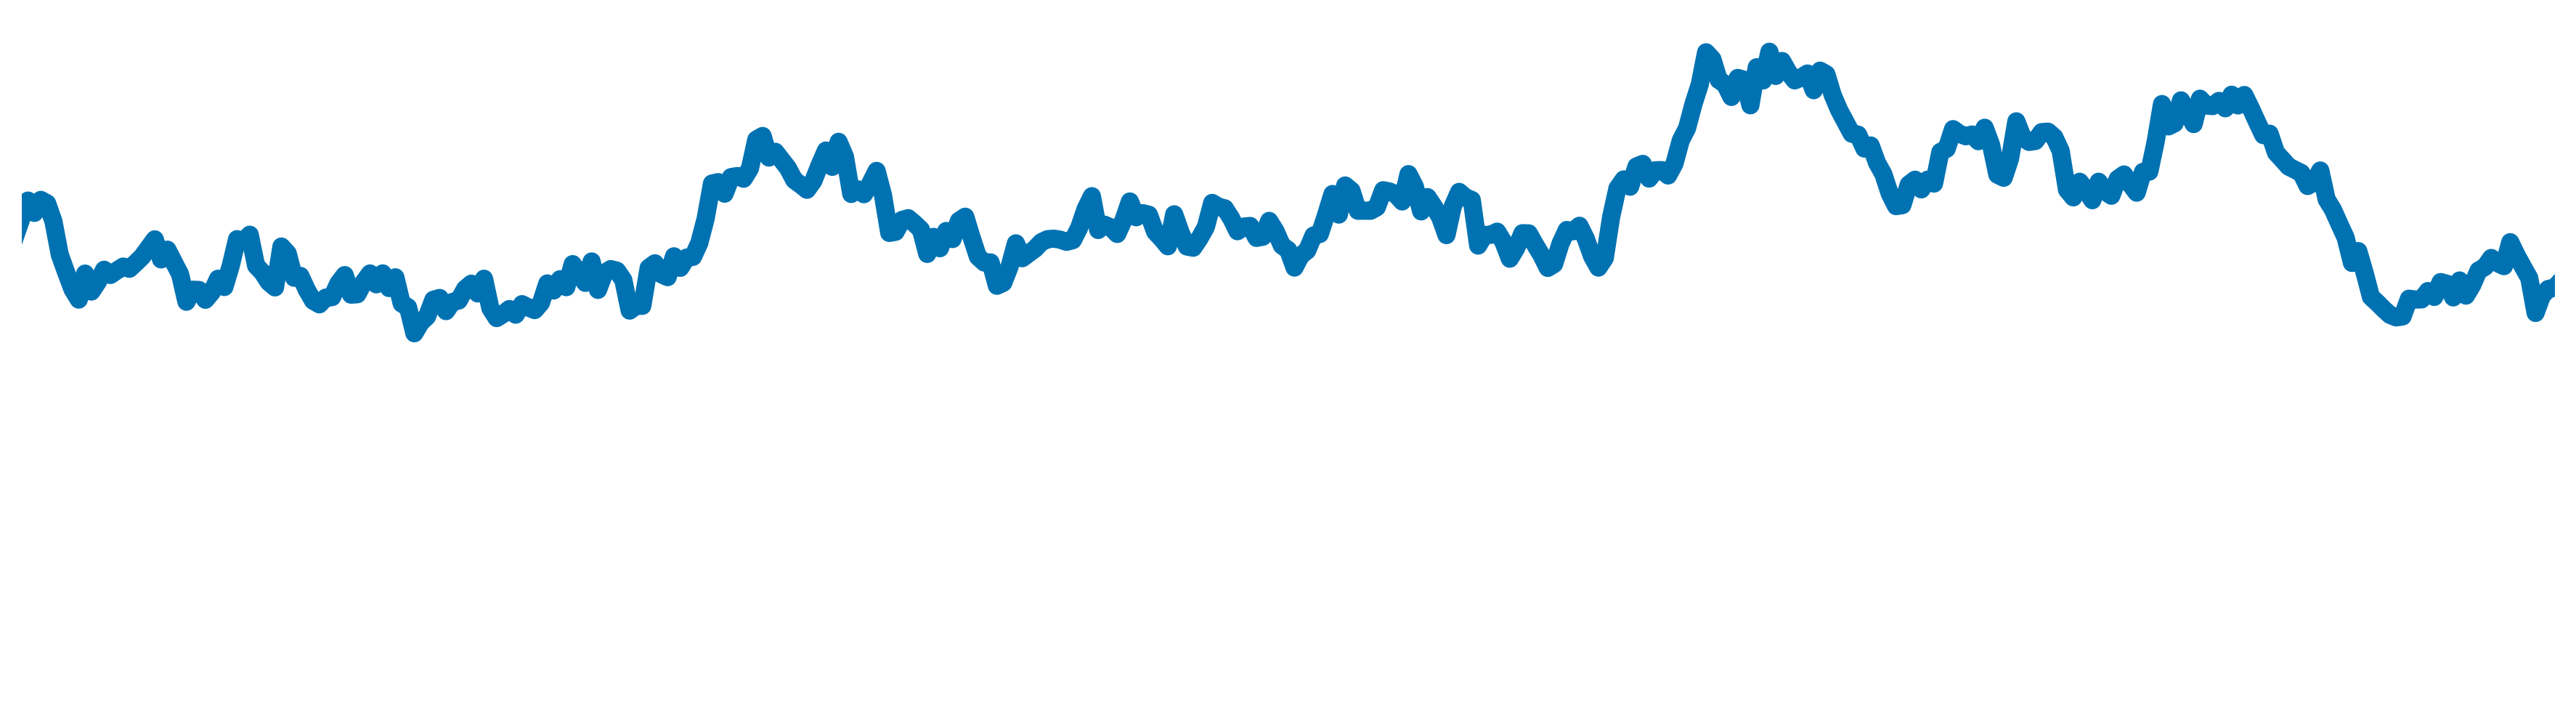

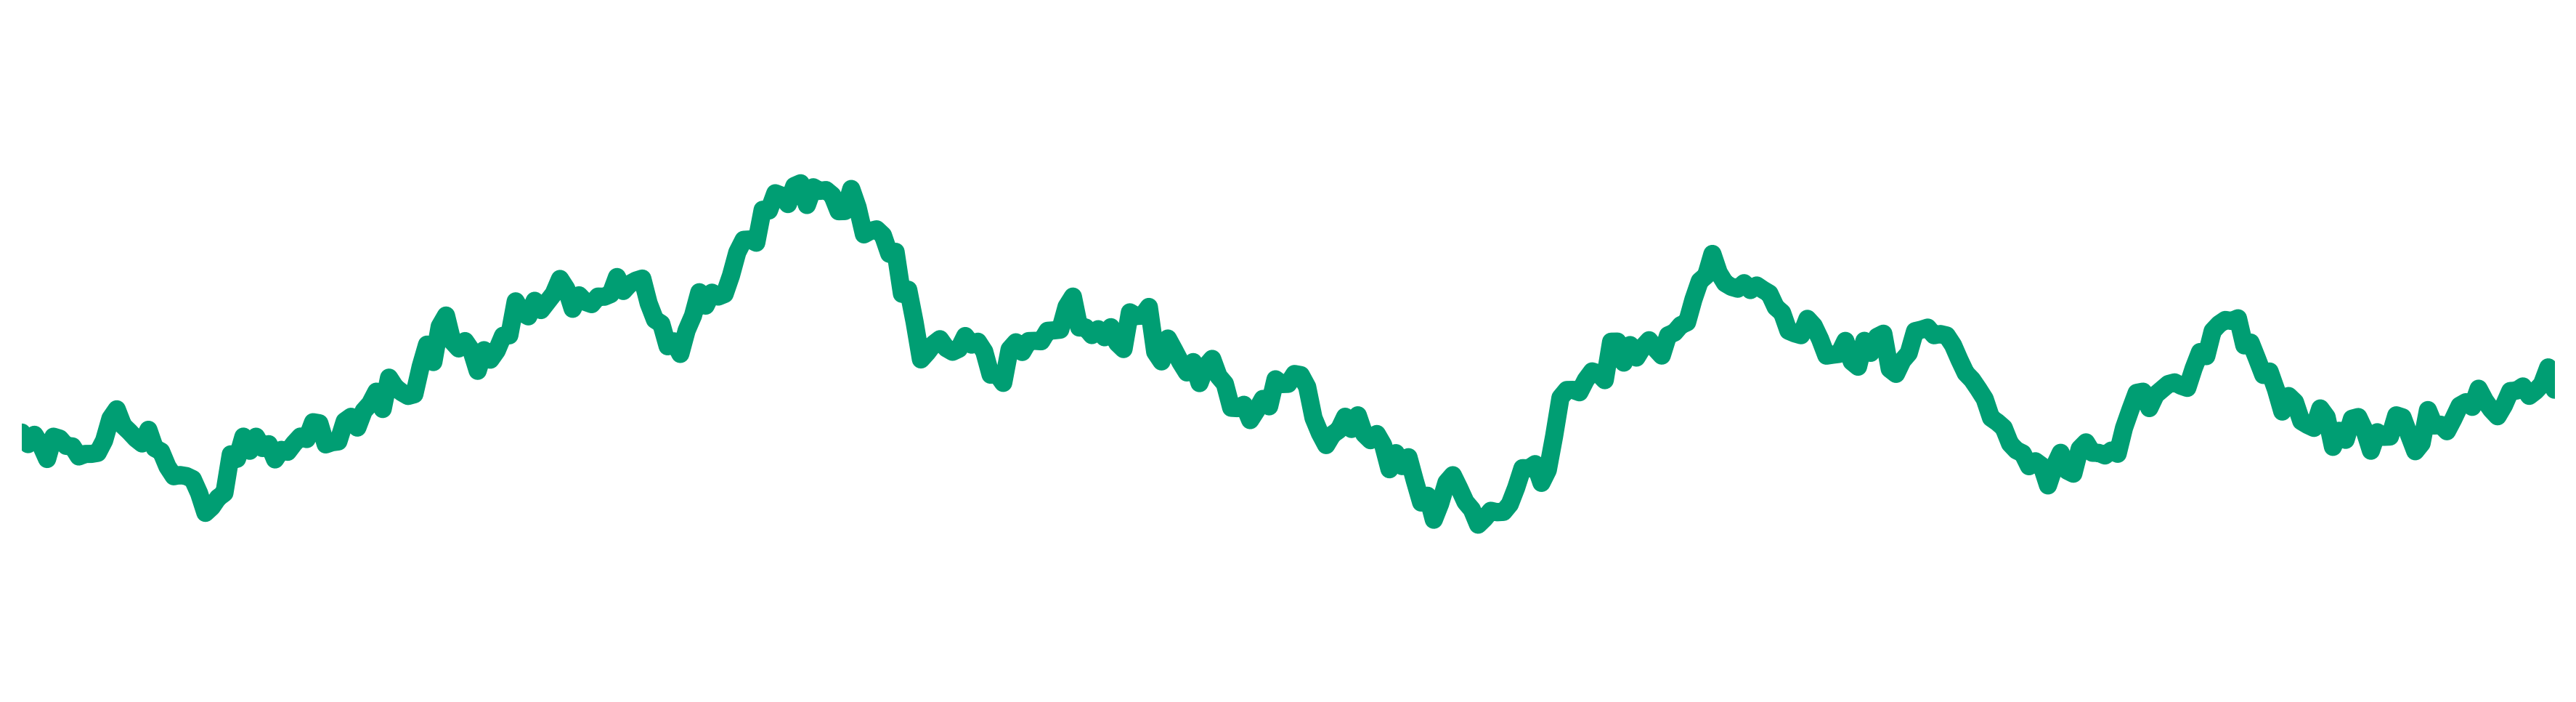

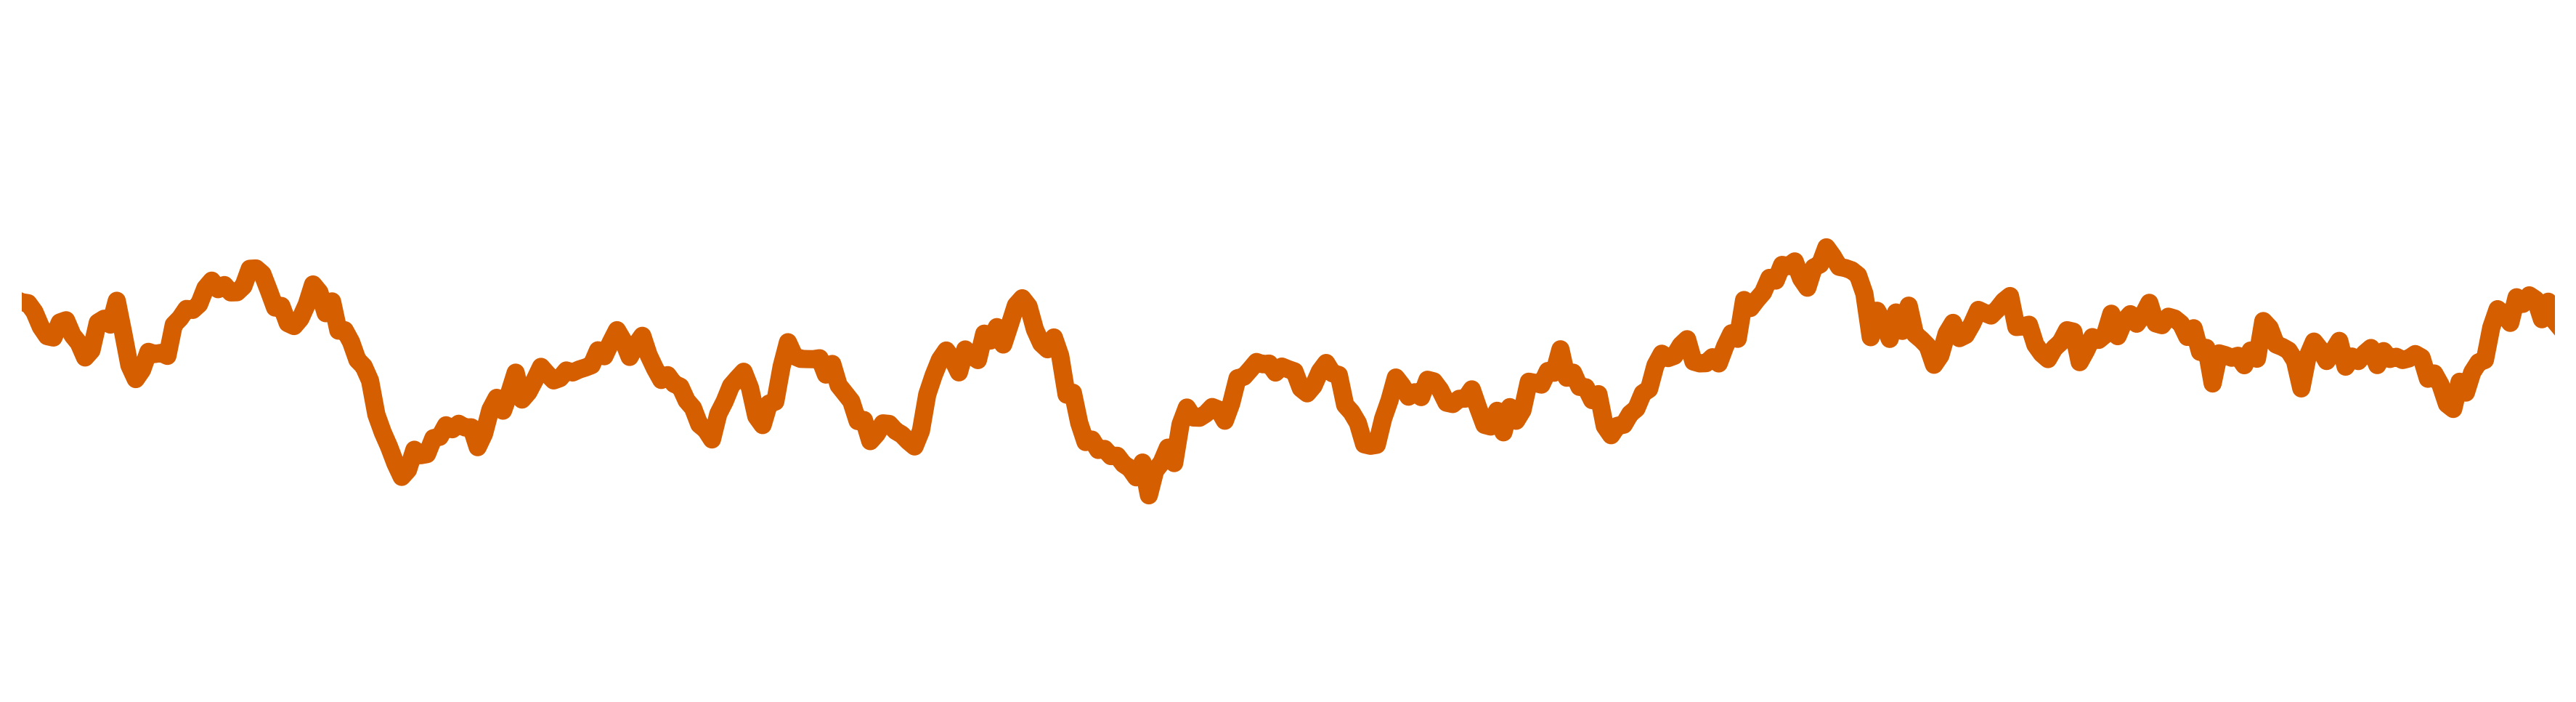

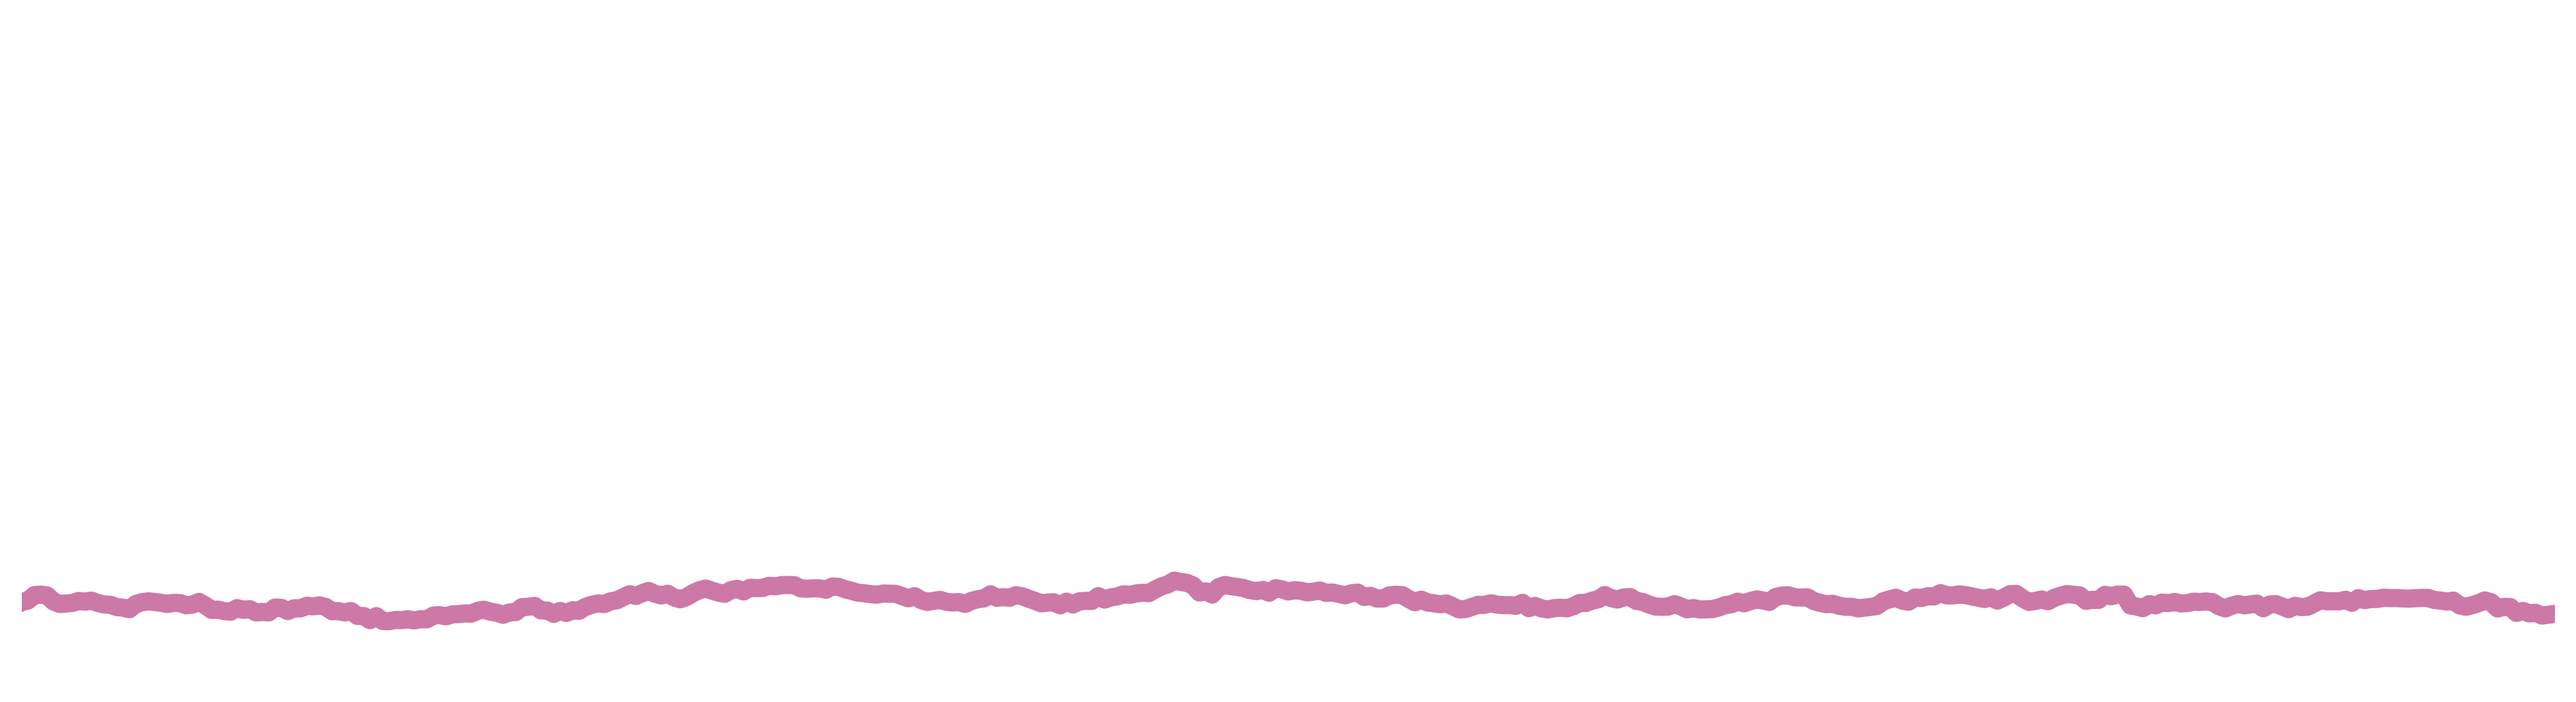

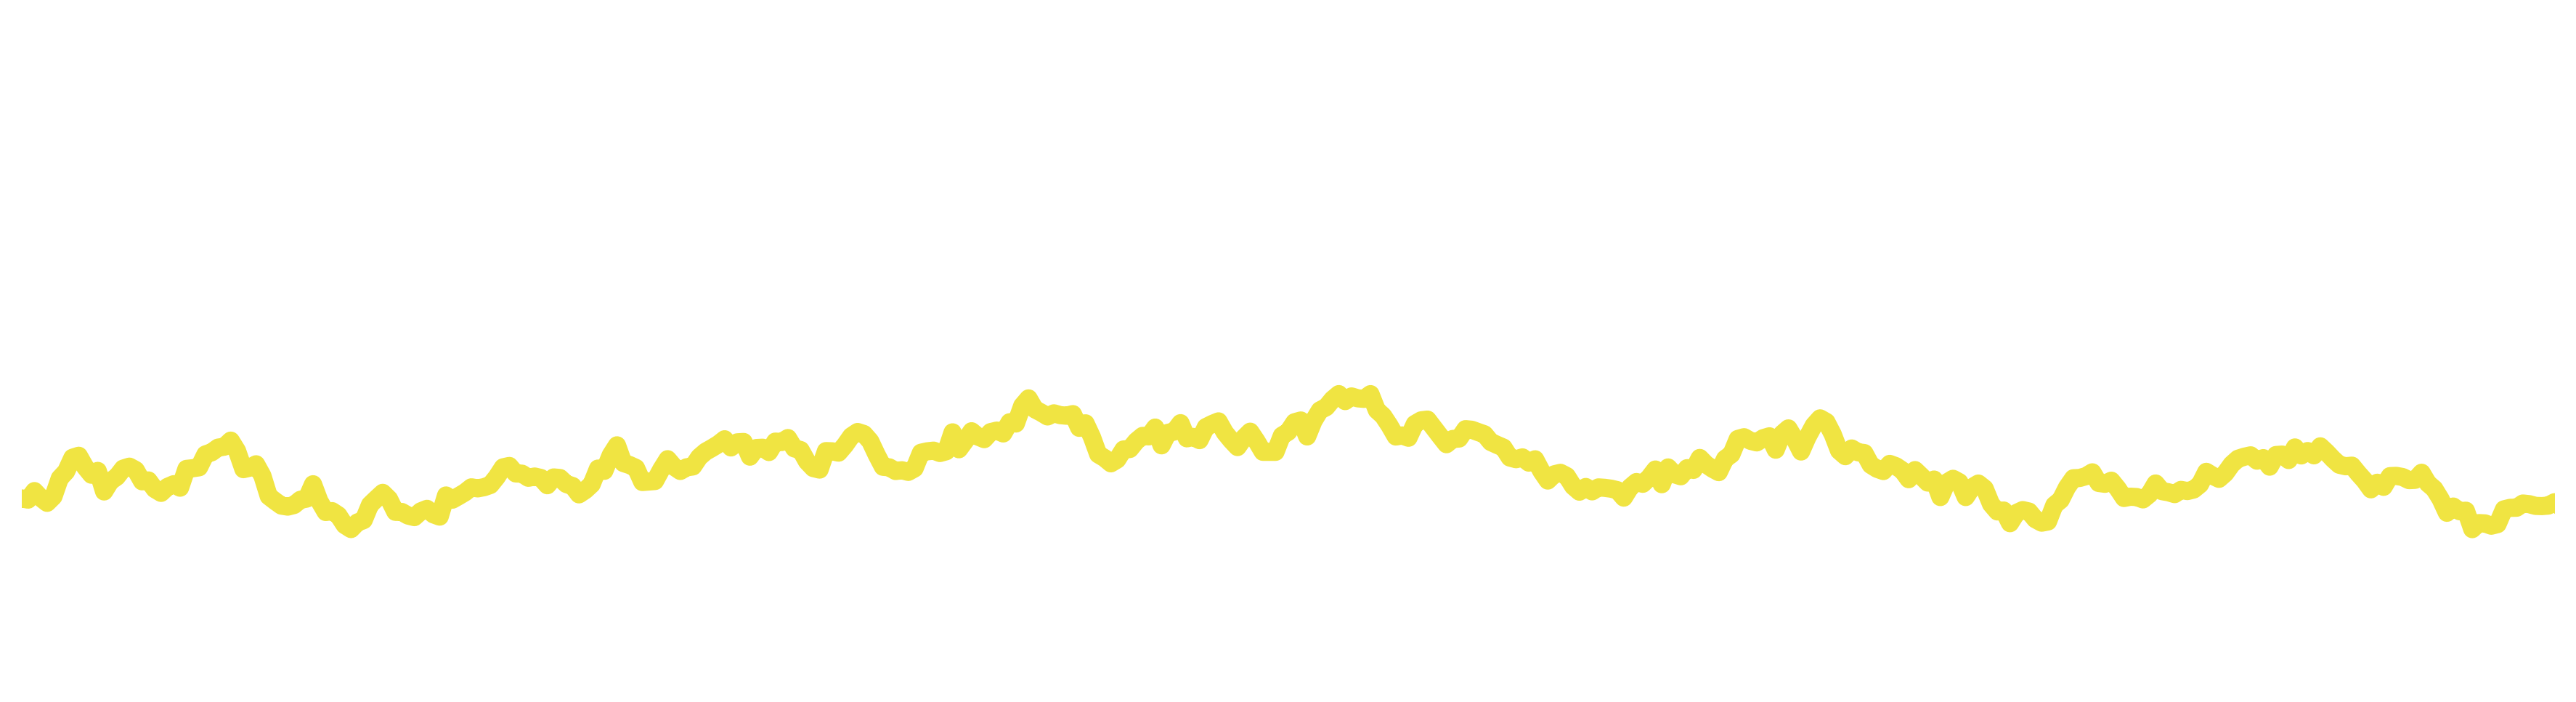

In [2]:
plt.figure(figsize=(15, 8))
plasticity = 'no_Plasticity'
Noise_output = output_load_run('Noise',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
for n_noise in range(5):
    plt.figure(figsize=(15, 4),dpi=300)
    plot(Noise_output['I'][n_noise]/nA*amp,color=f'C{n_noise}',lw=6)
#     yticks([])
#     ylim(0.7,3)
    xlim(20000,20400)
    sns.despine(left=True)
    axis('off')

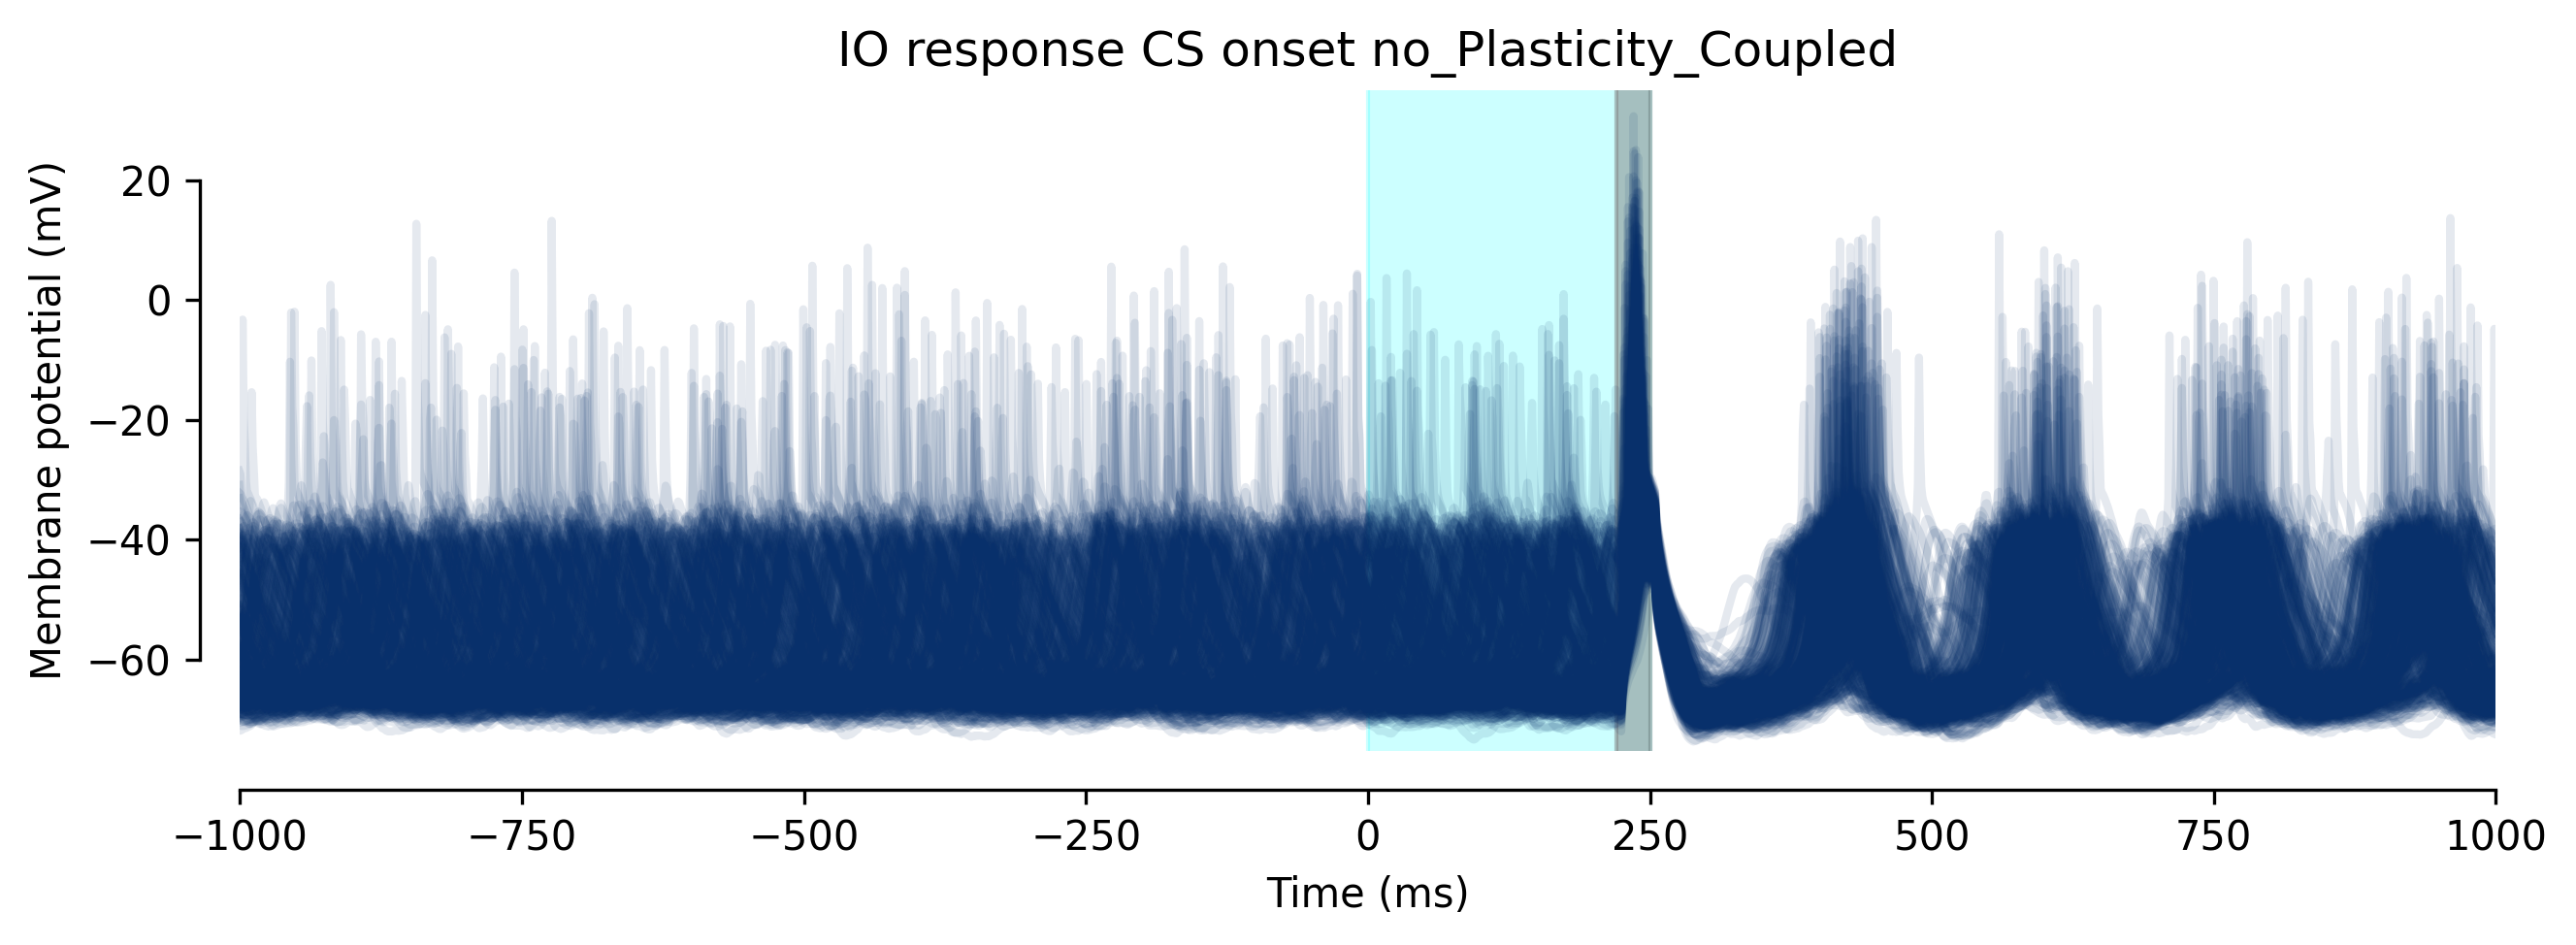

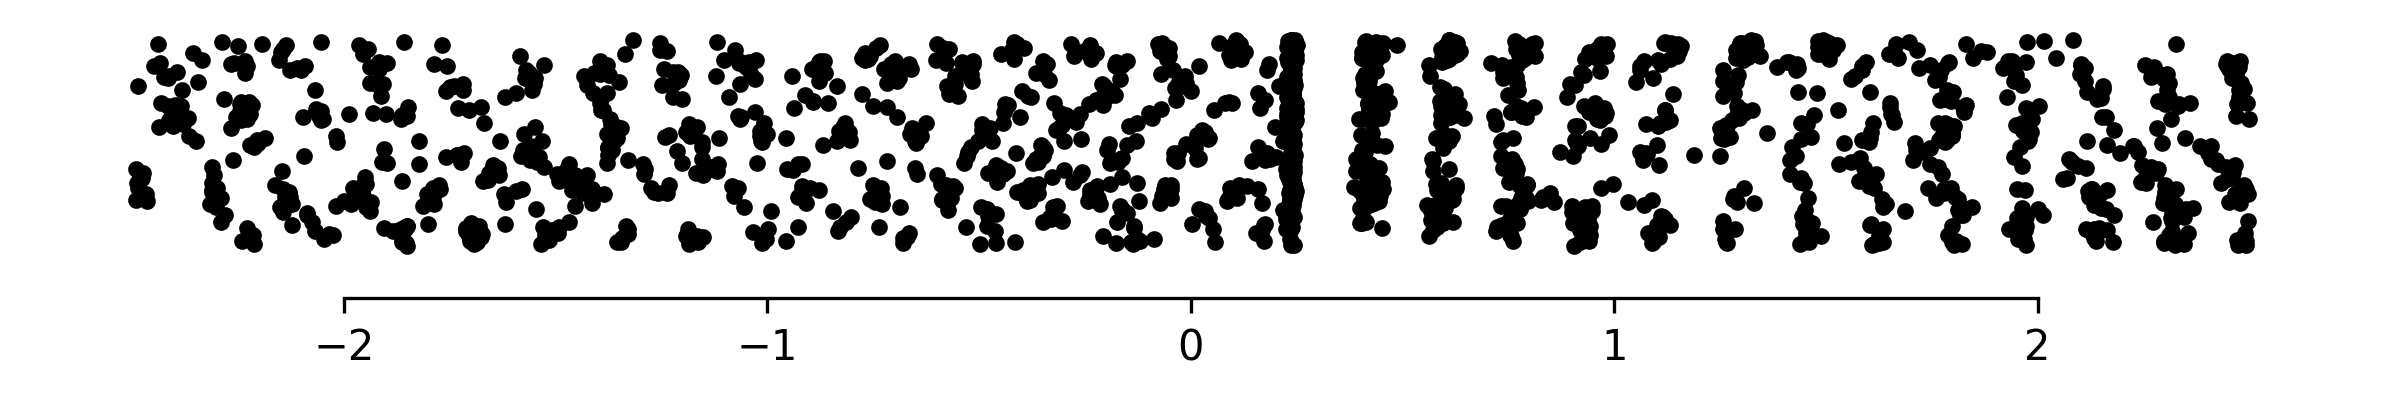

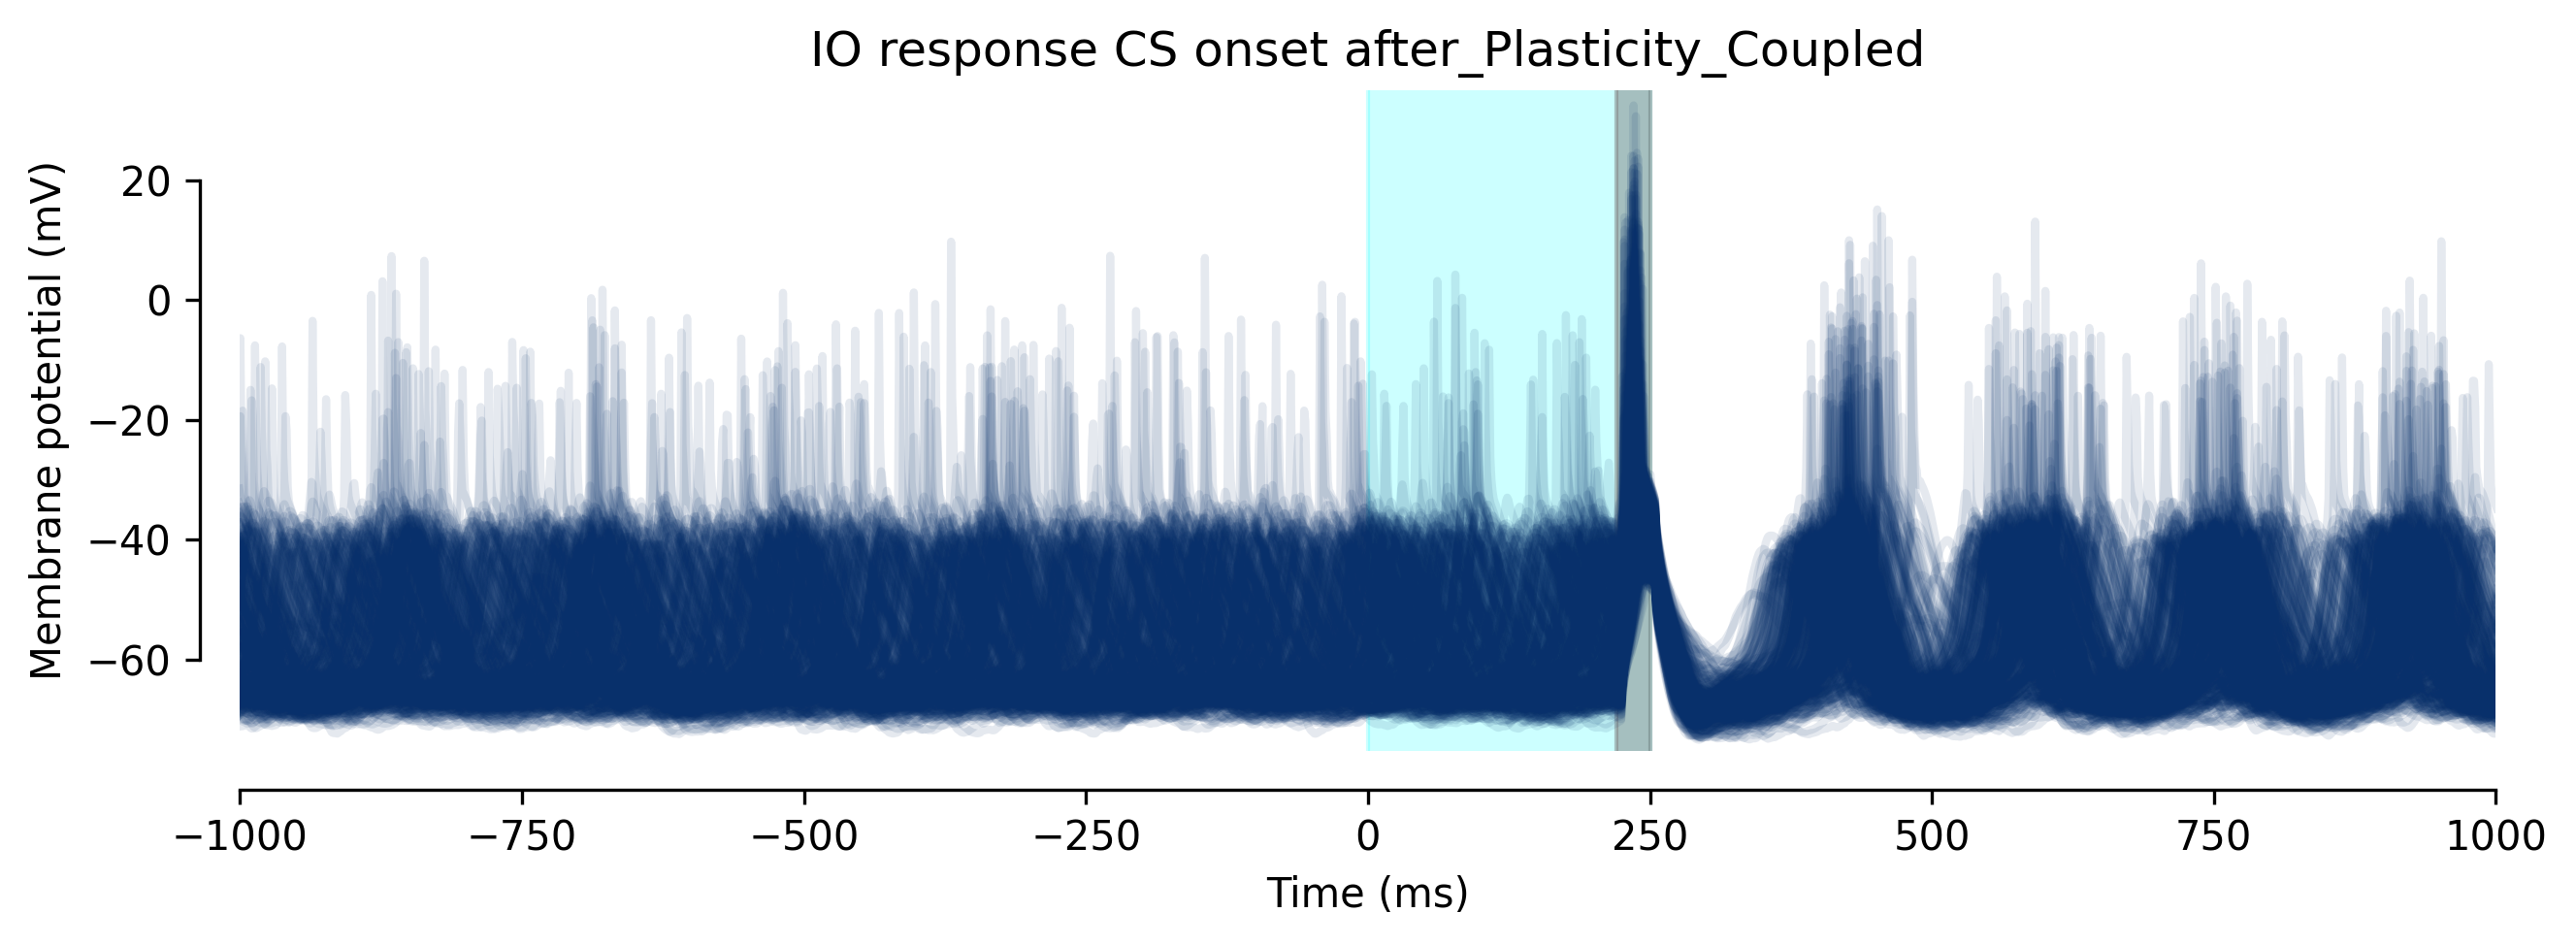

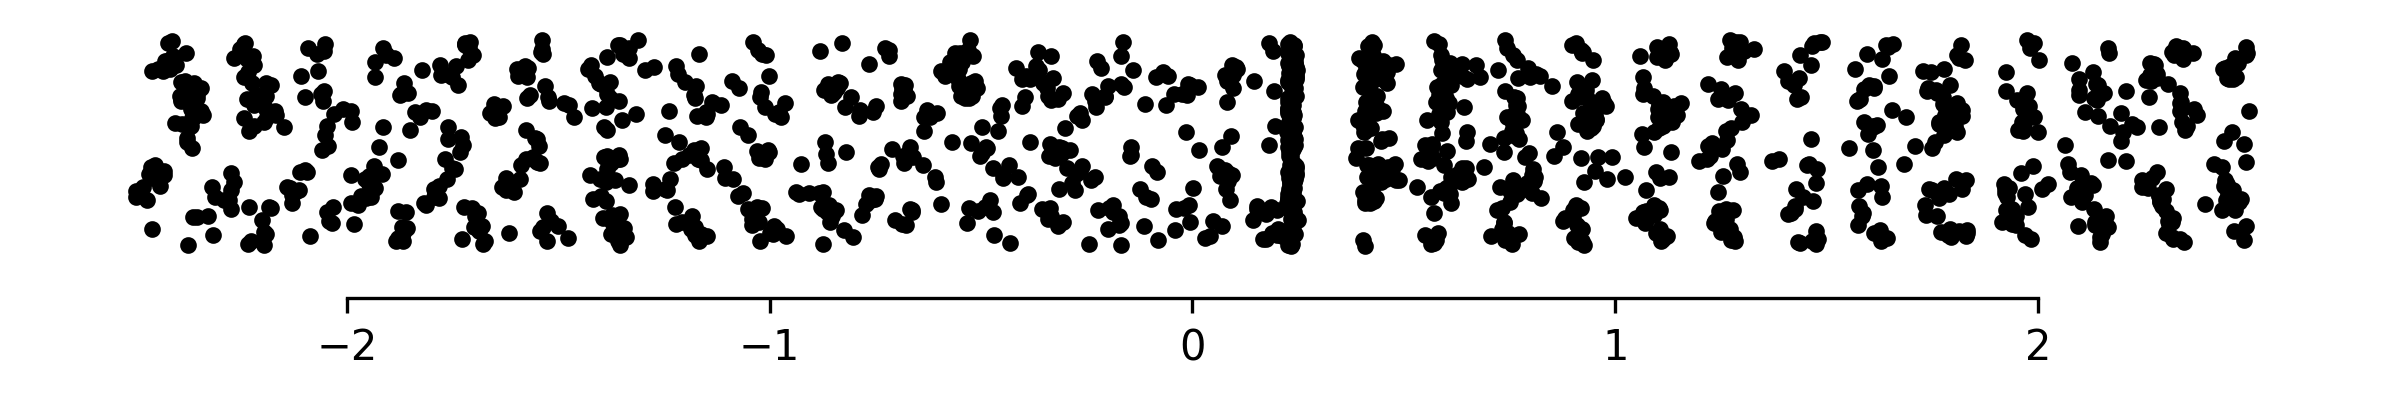

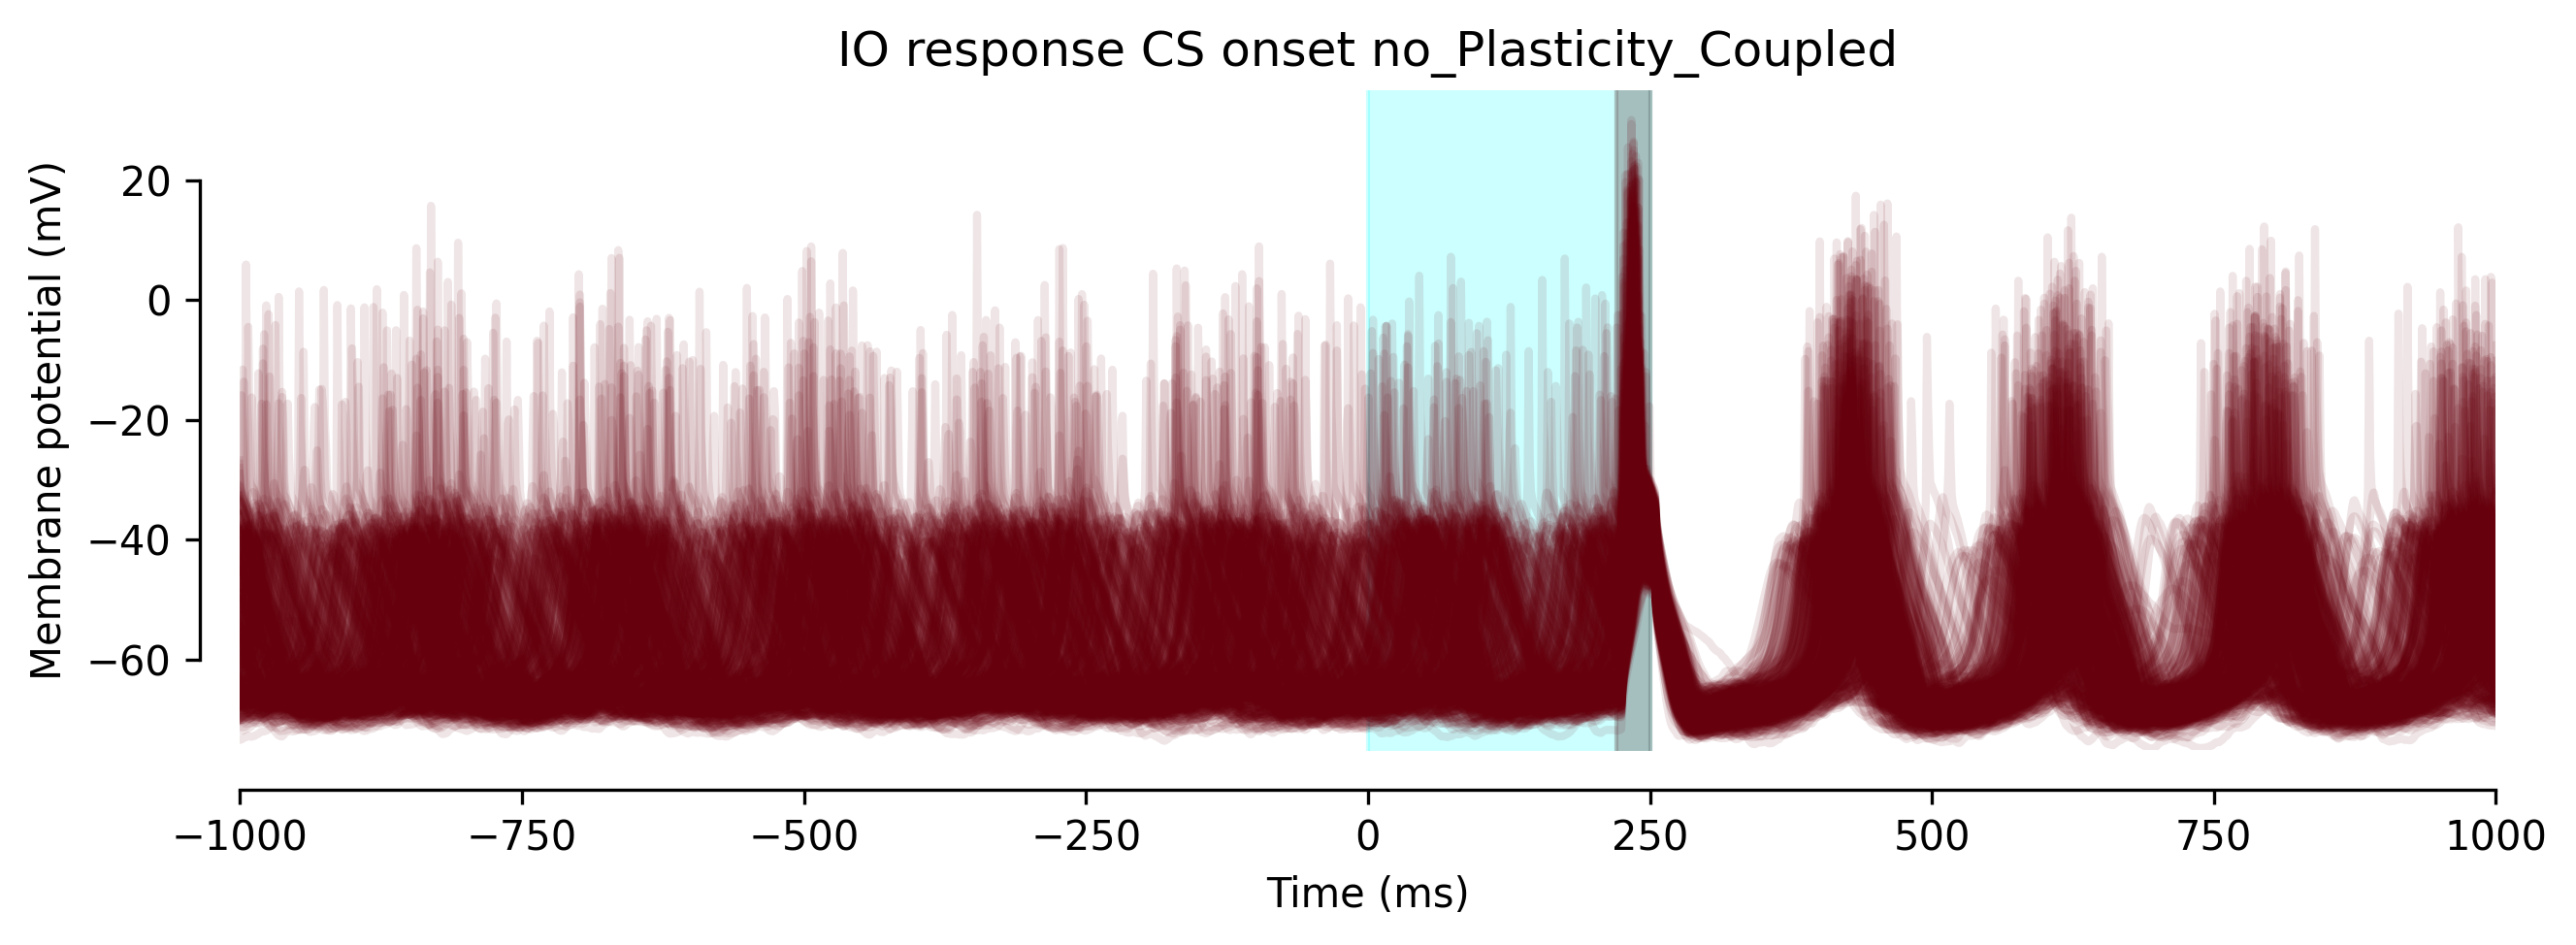

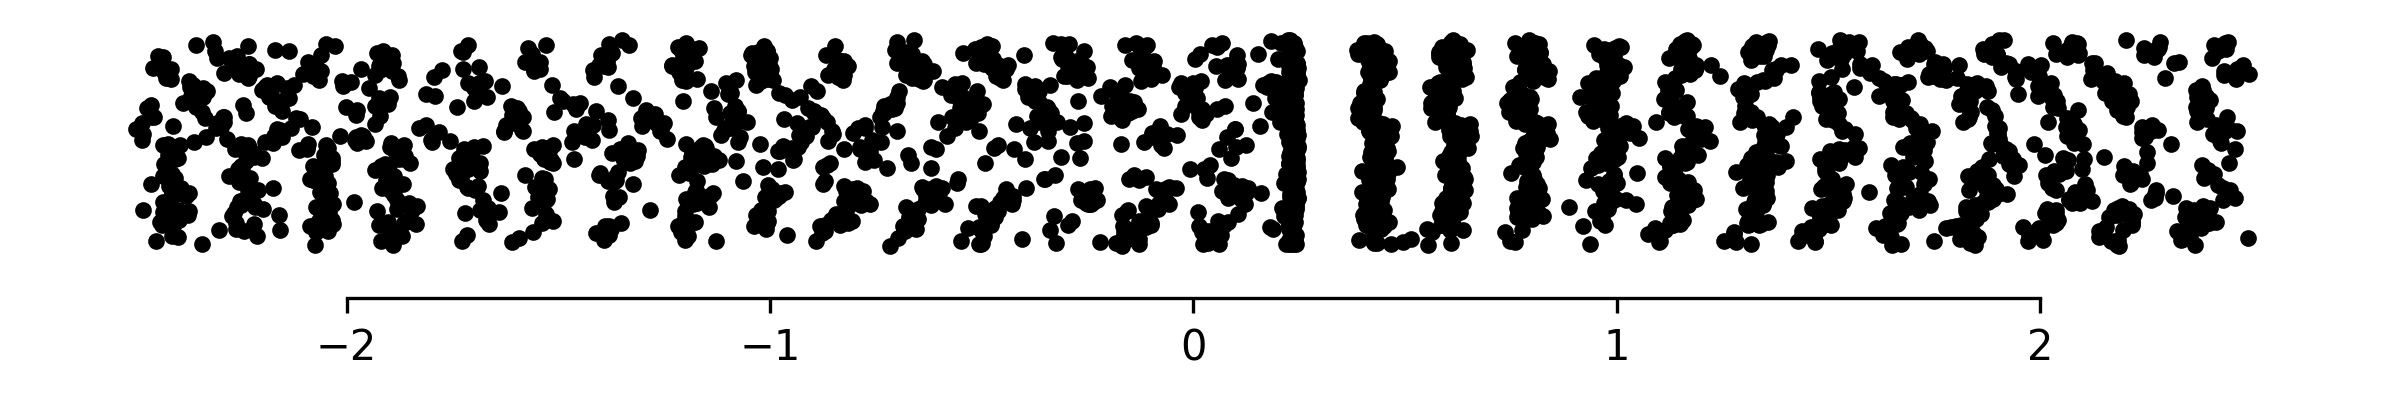

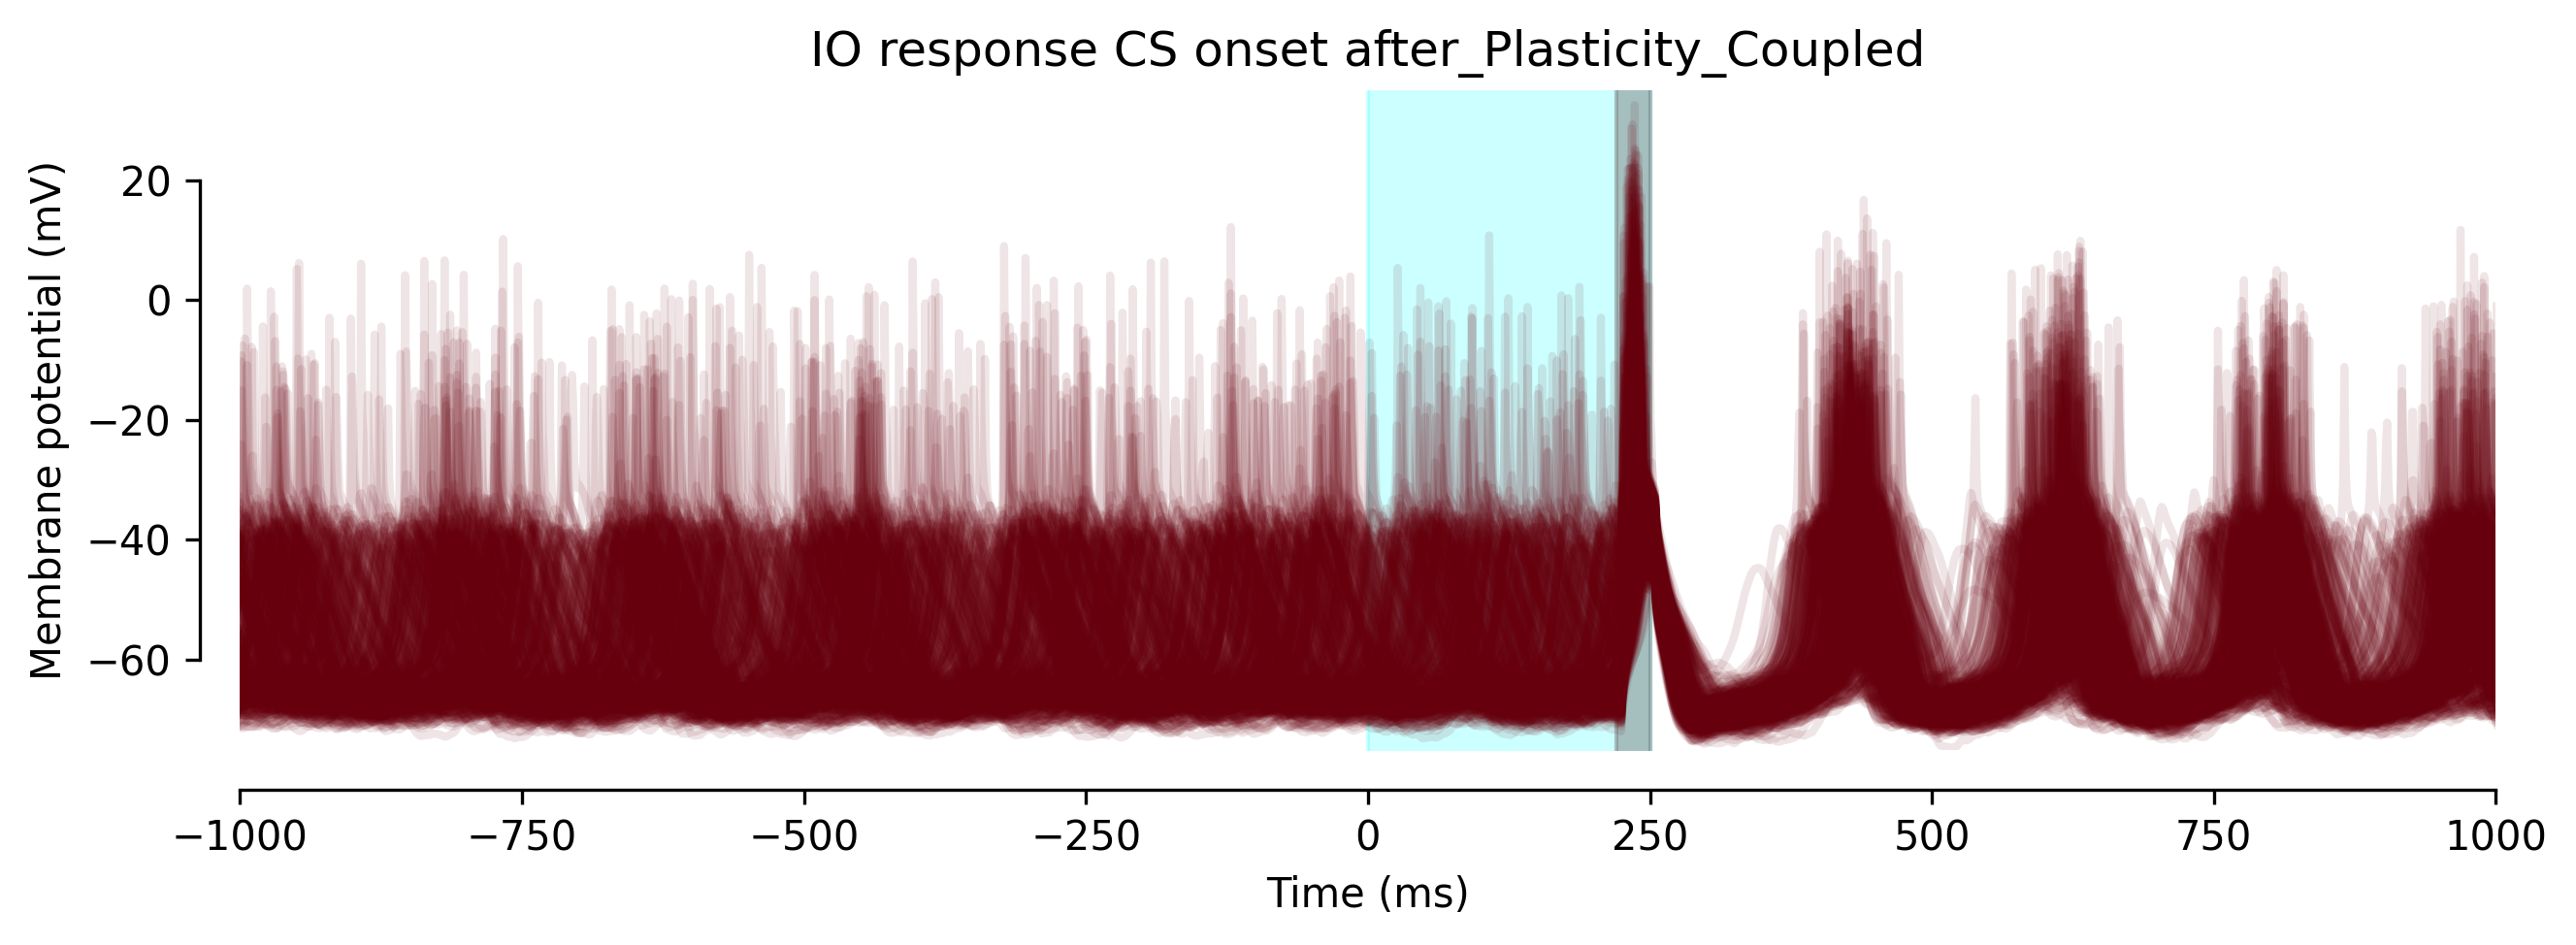

CPU times: user 9.2 s, sys: 2.36 s, total: 11.6 s
Wall time: 27.9 s


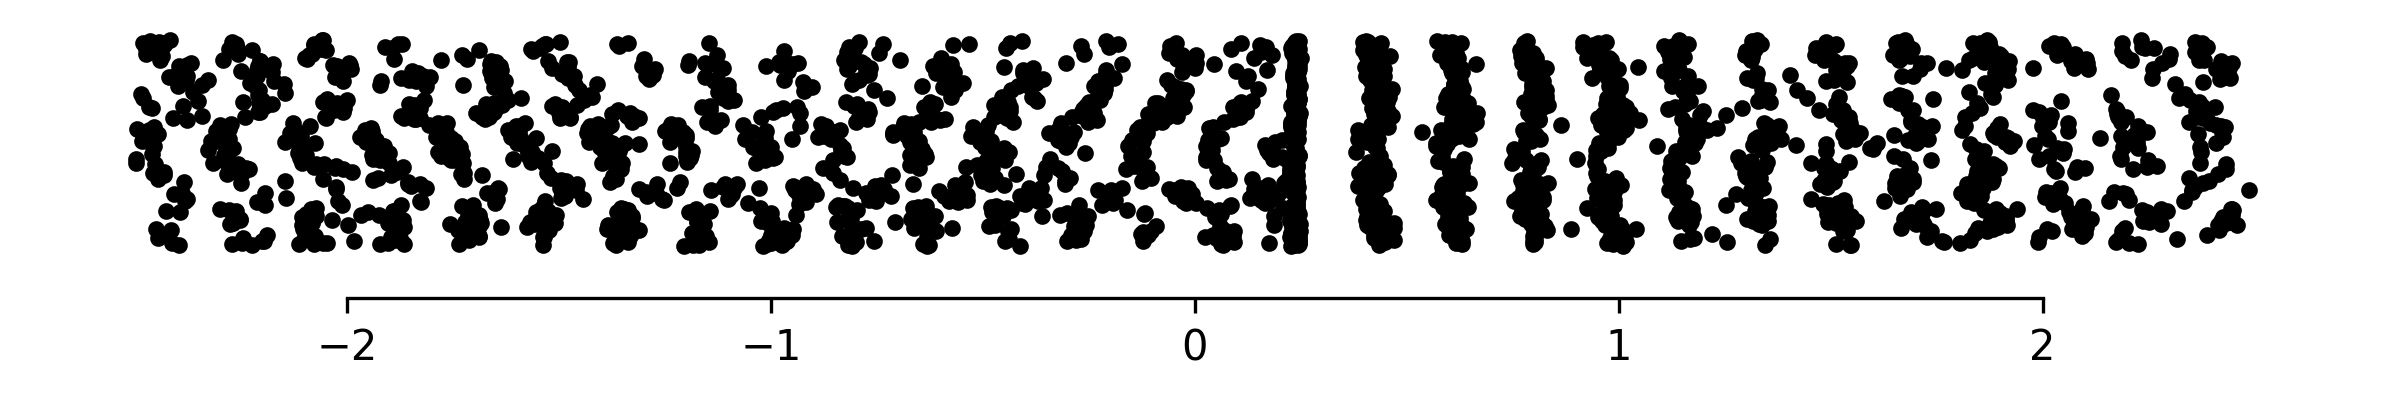

In [3]:
%%time
seed_number = 'eyeblink_int_4.2'
seed_number = seed_number_range[0]
Noise_sim = Noise_frozen[f'Seed_{seed_number}'].Noise_sim
iti_arr = Noise_sim['iti_arr_pulse']
# iti_arr = [10*second]*len(iti_arr)
iti_arr = iti_arr*second
iti_arr

CS_dur = 220*ms
US_dur = 30*ms
transient = iti_arr[0]
ini_US_onset = transient
ini_US_ofset = transient+US_dur
CS_onset = [ini_US_ofset+iti_arr[1]]
US_onset = [CS_onset[0]+CS_dur]
CS_ofset = [CS_onset[0]+CS_dur+US_dur]
US_ofset = [US_onset[0]+US_dur]

for idx,iti in enumerate(iti_arr[2:-1]):
    CS_onset.append(CS_ofset[idx]+iti)
    US_onset.append(US_ofset[idx]+iti+CS_dur)
    CS_ofset.append(CS_ofset[idx]+iti+CS_dur+US_dur)
    US_ofset.append(US_ofset[idx]+iti+CS_dur+US_dur)

fin_CS_onset = CS_ofset[-1]+iti_arr[-1]
fin_CS_ofset = fin_CS_onset+CS_dur+US_dur


data=[]
plas_rang = ['no_Plasticity']
plas_rang.extend(range_after_plasticity)
step = 2.5

for f0 in f0_range[0:1]:
    for zebrin in ['negative','positive']:
        for plasticity in plas_rang:
            for coupling in ['_Coupled','']:
                IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources
                IO_output = output_load_run('IO',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for io_num in range(N_Cells_IO):
                    for spike_time in CS_onset:
                        spike_time=spike_time/second
                        start = int(spike_time*second/dt_rec)-int(step*second/dt_rec)
                        end = int(spike_time*second/dt_rec)+int(step*second/dt_rec)
                        if spike_time < step: continue
                        if spike_time+step > exp_run/second: continue
                        IO_trig_avg = IO_output['Vs'][io_num][start:end]/mV*volt
                        row=dict(cell=io_num,spiketime=spike_time,f0=f0,zebrin=zebrin,plasticity=plasticity,coupling=coupling,IO_trig_avg=IO_trig_avg)
                        data.append(row)
df_all_IO_CS_onset = pd.DataFrame(data) 

step = 2.5
coupling = '_Coupled'
for zebrin in zebrin_range:
    if zebrin == 'positive':
        cmap = plt.get_cmap('Blues')
    elif zebrin == 'negative':
        cmap = plt.get_cmap('Reds')
    for plasticity in plas_rang:
        figure(figsize=(10,3),dpi=300)
        title(f'IO response CS onset {plasticity}{coupling}')
        for dcn_num in range(N_Cells_IO):
            for spike_time in CS_onset:
                IO_trig_avg = df_all_IO_CS_onset[(df_all_IO_CS_onset['cell']==dcn_num)&(df_all_IO_CS_onset['spiketime']==spike_time)&(df_all_IO_CS_onset['zebrin']==zebrin)&(df_all_IO_CS_onset['plasticity']==plasticity)&(df_all_IO_CS_onset['f0']==f0)&(df_all_IO_CS_onset['coupling']==coupling)]
                if IO_trig_avg.empty:
                    continue
                IO_trig_avg = IO_trig_avg.iloc[0]['IO_trig_avg']
                plot(linspace(-step*1000,step*1000,len(IO_trig_avg)),IO_trig_avg,lw=2,color=cmap(3*(2+10*dcn_num/3)),alpha=0.1,label=plasticity)
        xlim(-1000,1000)
        fill_between([0, 250],[-80,-80],[50,50], color='cyan', alpha=0.2)
        fill_between([220, 250],[-80,-80],[50,50], color='grey', alpha=0.5)
#         axvline(220)
#         axvline(250)
        ylim(-75,35)
#         axis('off')
        sns.despine(trim=True,offset=10)
        ylabel('Membrane potential (mV)')
        xlabel('Time (ms)')
#         plt.savefig(f'{zebrin} IO uncconnected response CS onset {plasticity}{coupling}.svg')
        plt.show()

        IO_spikes = output_load_run('IO_spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
        spike_arr = []
        for stim_time in CS_onset:
            for io_num in range(N_Cells_IO):
                small_arr = []
                for spike_time in IO_spikes[f'{io_num}']:
                    if stim_time/second - step < spike_time < stim_time/second + step:
                        small_arr.append(spike_time-stim_time/second)
                spike_arr.append(small_arr)
        fig= figure(figsize=(10,1), dpi= 300, facecolor='w', edgecolor='k')
        for idx,stim_time in enumerate(CS_onset):
            for io_num in range(idx*40,(idx+1)*40):
                x = spike_arr[io_num]
                y = [io_num]*len(spike_arr[io_num])
                plot(x,y,'.',color='k',lw=1) 
        # plt.xlim([start/1000,end/1000])
#         plt.axis('off')
        # ylim([-1, N_Cells_PC])
        yticks([])
        sns.despine(trim=True,offset=10,left=True)
#         plt.savefig(f'scatter{plasticity}{zebrin}.svg')

100%|██████████| 10/10 [00:00<00:00, 158.76it/s]


CPU times: user 2.18 s, sys: 8.41 s, total: 10.6 s
Wall time: 1min 45s


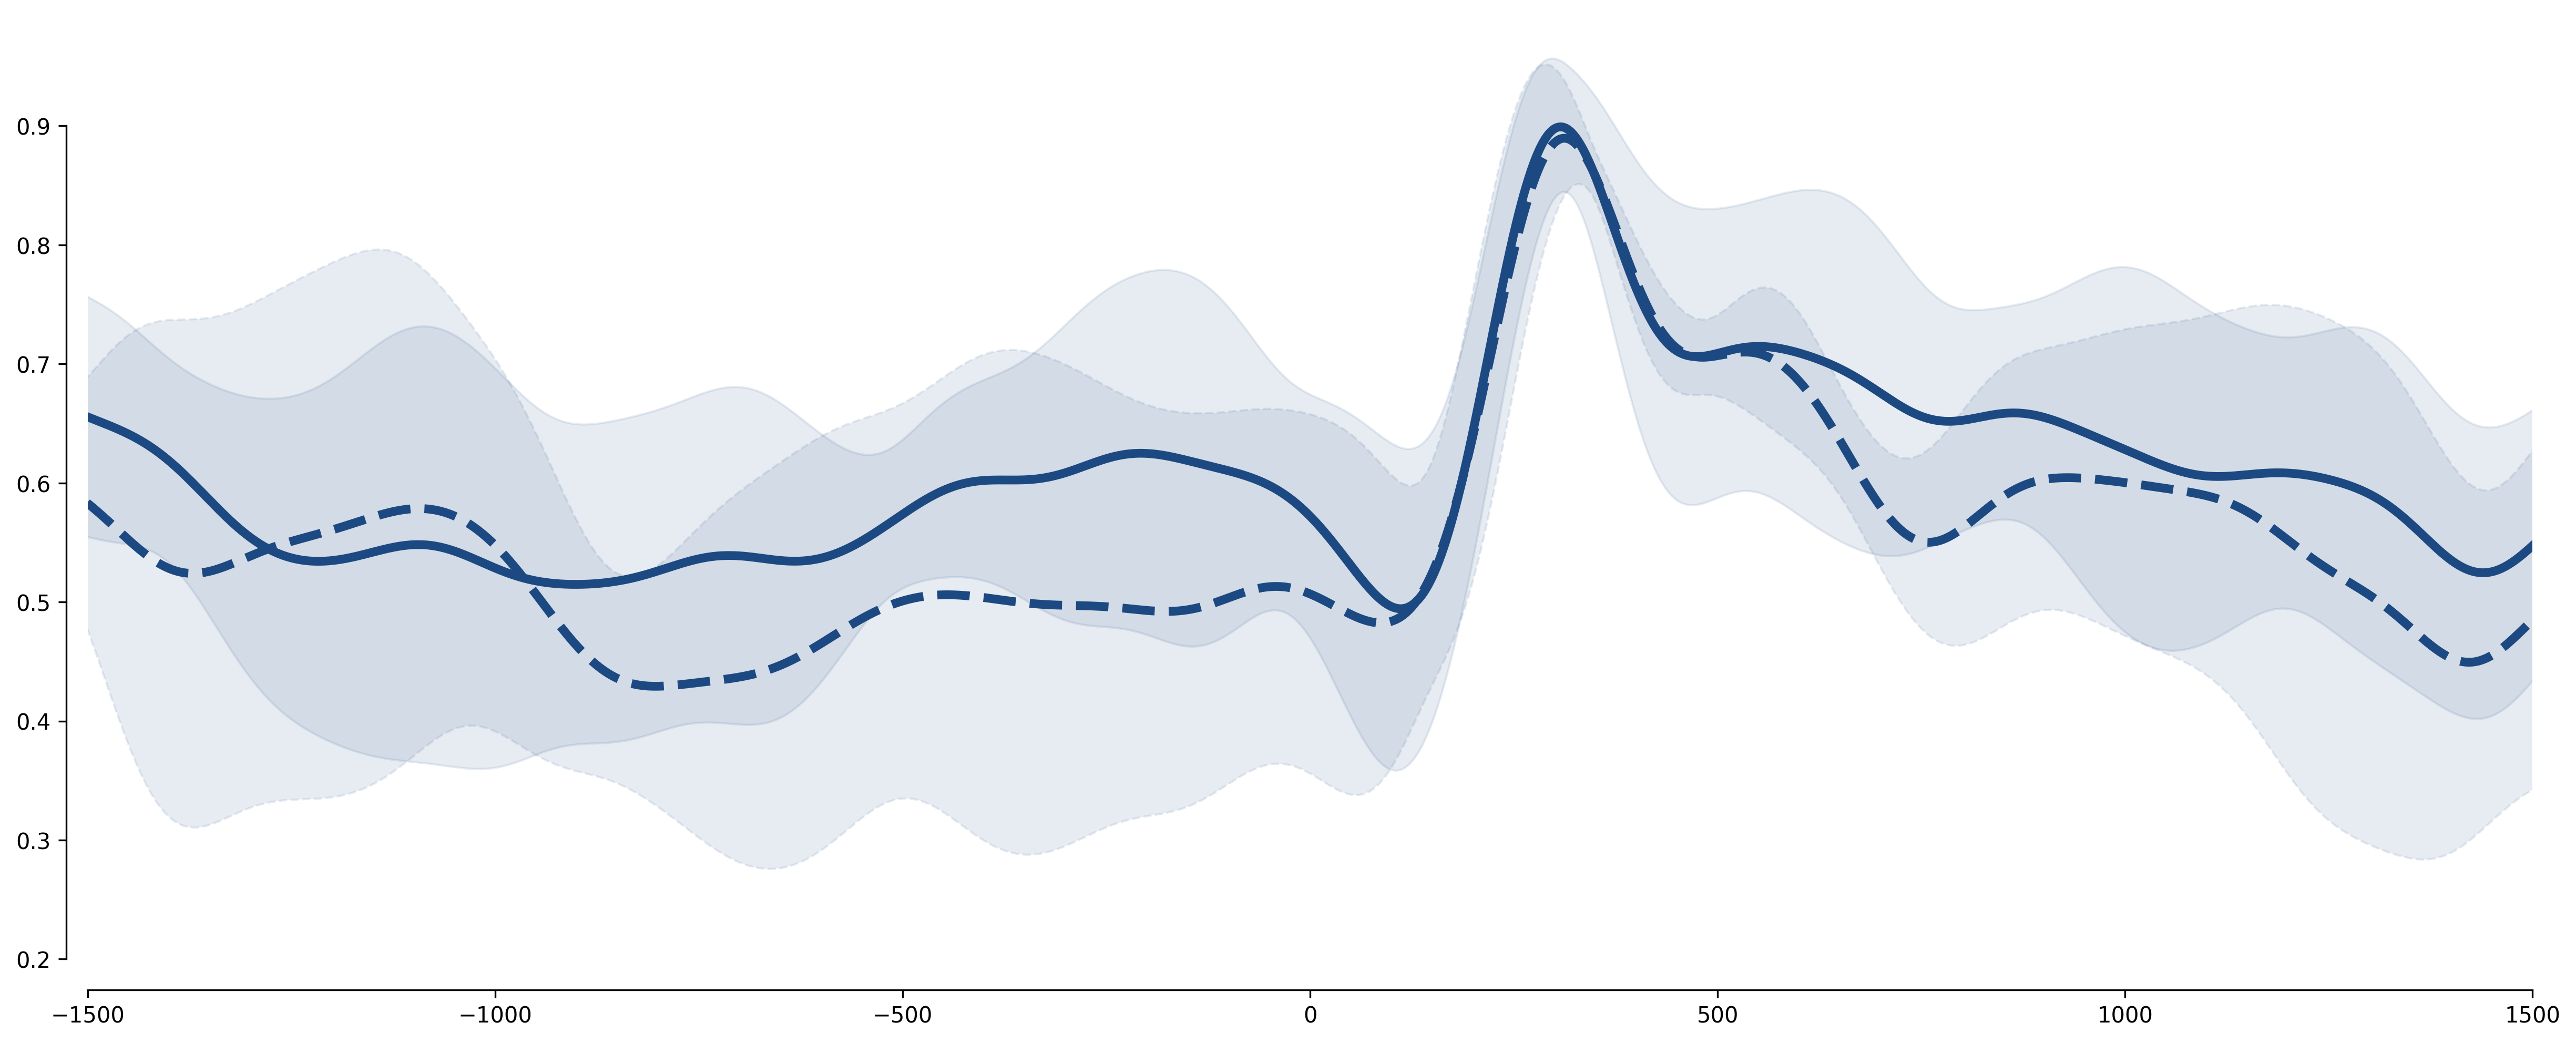

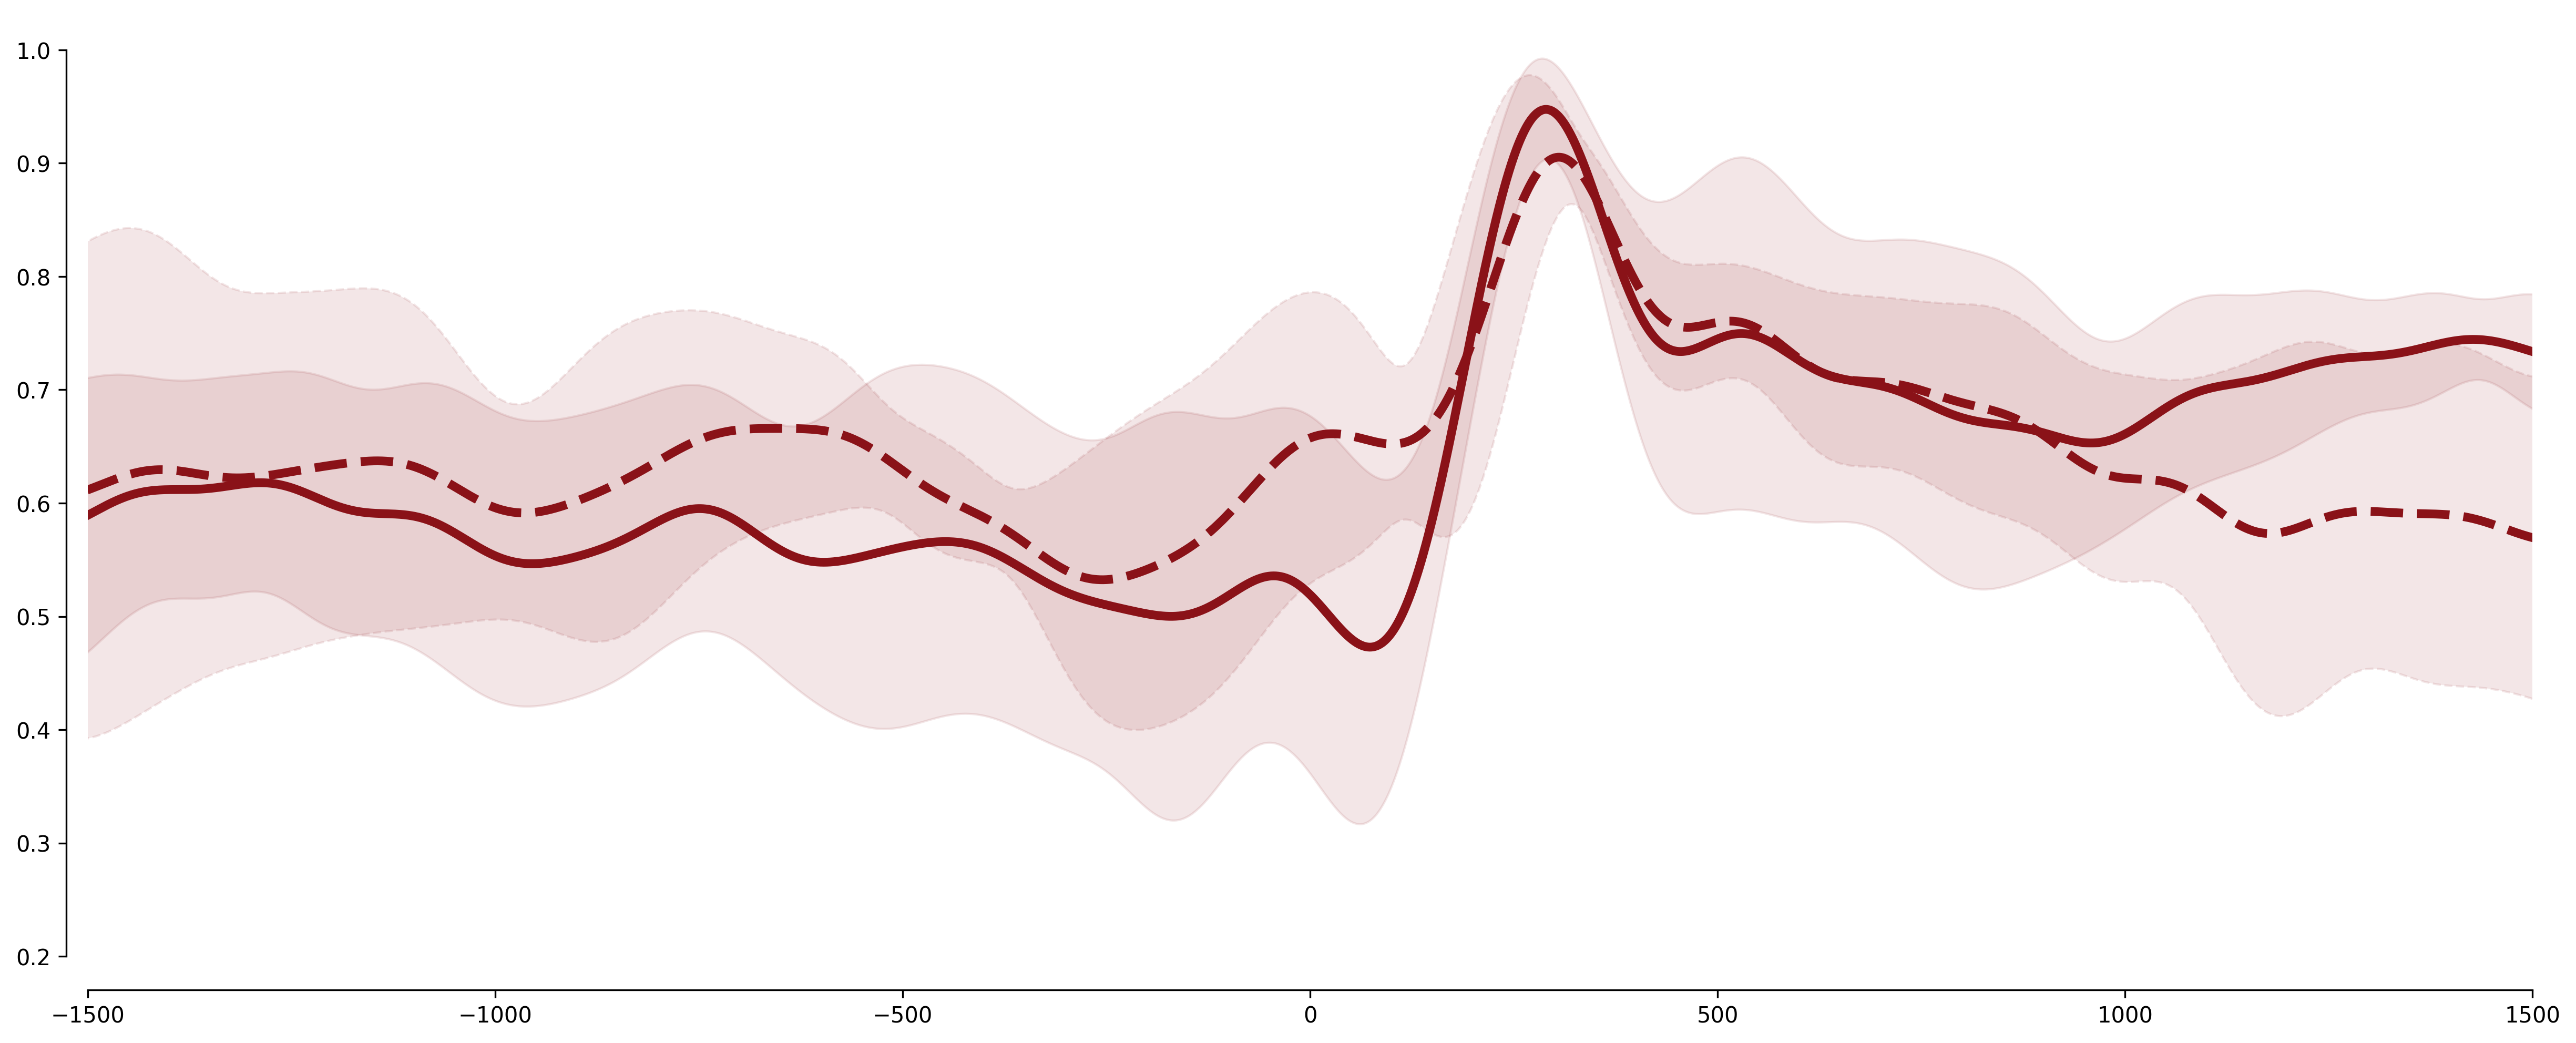

In [4]:
%%time
import collections
import scipy.signal
import tqdm
import functools
from IPython.display import HTML, display

@functools.lru_cache
def load_io_vs(coupling=True, plasticity=True, zebrin=True, n=0, f0=f0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    IO_output = output_load_run('IO',
                                '_Coupled' if coupling else '',seed_number,
                                p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)
    return np.array(IO_output['Vs']/mV)



@functools.lru_cache
def load_io_spikes(coupling=True, plasticity=True, zebrin=True, n=0, f0=f0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    o = output_load_run('IO_spikes','_Coupled' if coupling else '',seed_number,
                           p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)

    x = []
    for i in range(N_Cells_IO):
        x.append(o[str(i)])
    return x

@functools.lru_cache
def load_pc_psc(coupling=True, plasticity=True, zebrin=True, n=0, f0=f0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    o = output_load_run('PC',
                                '_Coupled' if coupling else '',seed_number,
                                p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)
    return np.array(o['I_Noise']/nA*amp)



class Case(collections.abc.Mapping):
    def __init__(self, **kw):
        self.kw = kw
        for k in kw:
            assert k in ['coupling', 'zebrin', 'plasticity']
    def __len__(self):
        return 1
    def __getitem__(self, k):
        return self.kw[k]
    def __iter__(self):
        return iter(self.kw)
    def __eq__(self, other):
        for k in ['coupling', 'zebrin', 'plasticity']:
            if self.kw.get(k, '*') !=  other.kw.get(k, '*'):
                return False
        return True
    def __hash__(self):
        return __builtins__.sum(hash(f'{k}{self.kw.get(k, "*")}') for k in ['coupling', 'zebrin', 'plasticity'])
    @property
    def before(self):
        kw = dict(self.kw)
        kw['plasticity'] = False
        return Case(**kw)
    @property
    def after(self):
        kw = dict(self.kw)
        kw['plasticity'] = True
        return Case(**kw)
    @property
    def during(self):
        kw = dict(self.kw)
        kw['plasticity'] = None
        return Case(**kw)
    def __repr__(self):
        return '/'.join([
            {True: 'C', False: 'U', '*': '*'}[self.kw.get('coupling', '*')],
            {True: 'Z+', False: 'Z-', '*': '*'}[self.kw.get('zebrin', '*')],
            {True: 'AP', False: 'NP', None: 'P', '*': '*'}[self.kw.get('plasticity', '*')]])
    
import tqdm
def stvmsync(ev, vm, transient_ms=10000, window_ms=500, skip=1, **k):
    windows = []
    for s1 in tqdm.tqdm(ev * 1000):
        if np.random.random() > skip: continue
        if s1 - window_ms < transient_ms or s1 + window_ms > 60000: continue
        v = vm[:,int(round(s1 - window_ms)):int(round(s1 + window_ms))]
        if v.shape[1] != window_ms*2: continue
        kp = calc_synchrony(v, lp=4, lpsync=4)
        windows.append(kp)
    w = np.stack(windows)
    x = np.arange(-window_ms, +window_ms)
    return x, w

def calc_synchrony(vs, fs=1000, order=5, lp=8, hp=15, lpsync=5):
    'Ncells x Ntimesteps -> Ntimesteps'
    # synchrony changing faster than 5Hz doens't make sense for 10Hz STO's
    sos = scipy.signal.butter(order, (lp, hp), 'bp', fs=fs, output='sos')
    filt = scipy.signal.sosfiltfilt(sos, vs)
    analytic = scipy.signal.hilbert(filt - filt.mean())
    angle = np.exp(1j*np.angle(analytic))
    synchrony = abs(angle.mean(0))
    sos = scipy.signal.butter(order, lpsync, 'lp', fs=fs, output='sos')
    return scipy.signal.sosfiltfilt(sos, synchrony)

seed_number = seed_number_range[0]

f0_range = ['pulse']

Noise_sim = Noise_frozen[f'Seed_{seed_number}'].Noise_sim
iti_arr = Noise_sim['iti_arr_pulse']
# iti_arr = [10*second]*len(iti_arr)
iti_arr = iti_arr*second
iti_arr

CS_dur = 220*ms
US_dur = 30*ms
transient = iti_arr[0]
ini_US_onset = transient
ini_US_ofset = transient+US_dur
CS_onset = [ini_US_ofset+iti_arr[1]]
US_onset = [CS_onset[0]+CS_dur]
CS_ofset = [CS_onset[0]+CS_dur+US_dur]
US_ofset = [US_onset[0]+US_dur]

for idx,iti in enumerate(iti_arr[2:-1]):
    CS_onset.append(CS_ofset[idx]+iti)
    US_onset.append(US_ofset[idx]+iti+CS_dur)
    CS_ofset.append(CS_ofset[idx]+iti+CS_dur+US_dur)
    US_ofset.append(US_ofset[idx]+iti+CS_dur+US_dur)

CS_onset = np.array(CS_onset)
US_onset = np.array(US_onset)
CS_ofset = np.array(CS_ofset)
US_ofset = np.array(US_ofset)

F0 = 'eye_blink'

        

CP = Case(coupling=True, zebrin=True)
CN = Case(coupling=True, zebrin=False)
UP = Case(coupling=False, zebrin=True)
UN = Case(coupling=False, zebrin=False)

cases = [CP, CN, UP, UN]


PC = 'pc'
DCN = 'dcn'
IO = 'io'

cells = [PC, DCN, IO]

spikes = {}
for case in cases:
    spikes[IO,   case.before] = load_io_spikes(**case.before)
    spikes[IO,   case.after]  = load_io_spikes(**case.after)
    
vm = {}
for case in cases:
    vm[IO,   case.before] = load_io_vs(**case.before)
    vm[IO,   case.after]  = load_io_vs(**case.after)
    vm[IO,   case.during]  = load_io_vs(**case.after)
    
psc = {}
for case in cases:
    psc[PC,   case.before] = load_pc_psc(**case.before)
    psc[PC,   case.after]  = load_pc_psc(**case.after)
    


pre = CS_onset



fig = plt.figure(figsize=(20, 8),dpi=300)
# fig.suptitle(f'Conditional Stimulus triggered IO synchrony')
cases2 = [CP.before, CN.before, CN.after, CP.after]

colors = dict(positive='#1c4981',negative='#8a1218')
case = CP.before
t, kp = stvmsync(pre, vm[IO, case], window_ms=2000)
plot(t, kp.mean(0), color='#1c4981',lw=4)
fill_between(t, kp.mean(0)-kp.std(0), kp.mean(0)+kp.std(0), alpha=0.1, color='#1c4981')
xlim([-1500, 1500])

case = CP.after
t, kp = stvmsync(pre, vm[IO, case], window_ms=2000)
plot(t, kp.mean(0), ls='--', color='#1c4981',lw=4)
fill_between(t, kp.mean(0)-kp.std(0), kp.mean(0)+kp.std(0), alpha=0.1, color='#1c4981', ls='--')
xlim([-1500, 1500])
sns.despine(trim=True,offset=10)
# plt.savefig('kura_pos.svg')
fig = plt.figure(figsize=(20, 8),dpi=300)
# fig.suptitle(f'Conditional Stimulus triggered IO synchrony')
case = CN.before
t, kp = stvmsync(pre, vm[IO, case], window_ms=2000)
plot(t, kp.mean(0), color='#8a1218',lw=4)
fill_between(t, kp.mean(0)-kp.std(0), kp.mean(0)+kp.std(0), alpha=0.1, color='#8a1218')
xlim([-1500, 1500])

case = CN.after
t, kp = stvmsync(pre, vm[IO, case], window_ms=2000)
plot(t, kp.mean(0), ls='--', color='#8a1218',lw=4)
fill_between(t, kp.mean(0)-kp.std(0), kp.mean(0)+kp.std(0), alpha=0.1, color='#8a1218', ls='--')
xlim([-1500, 1500])
sns.despine(trim=True,offset=10)
# plt.savefig('kura_neg.svg')

# left.set_ylabel('Kuramoto phase ([0-1])')
# left.set_xlabel('Time since CS onset (ms)')
# right.set_xlabel('Time since CS onset (ms)')

# left.set_ylim([0,1])

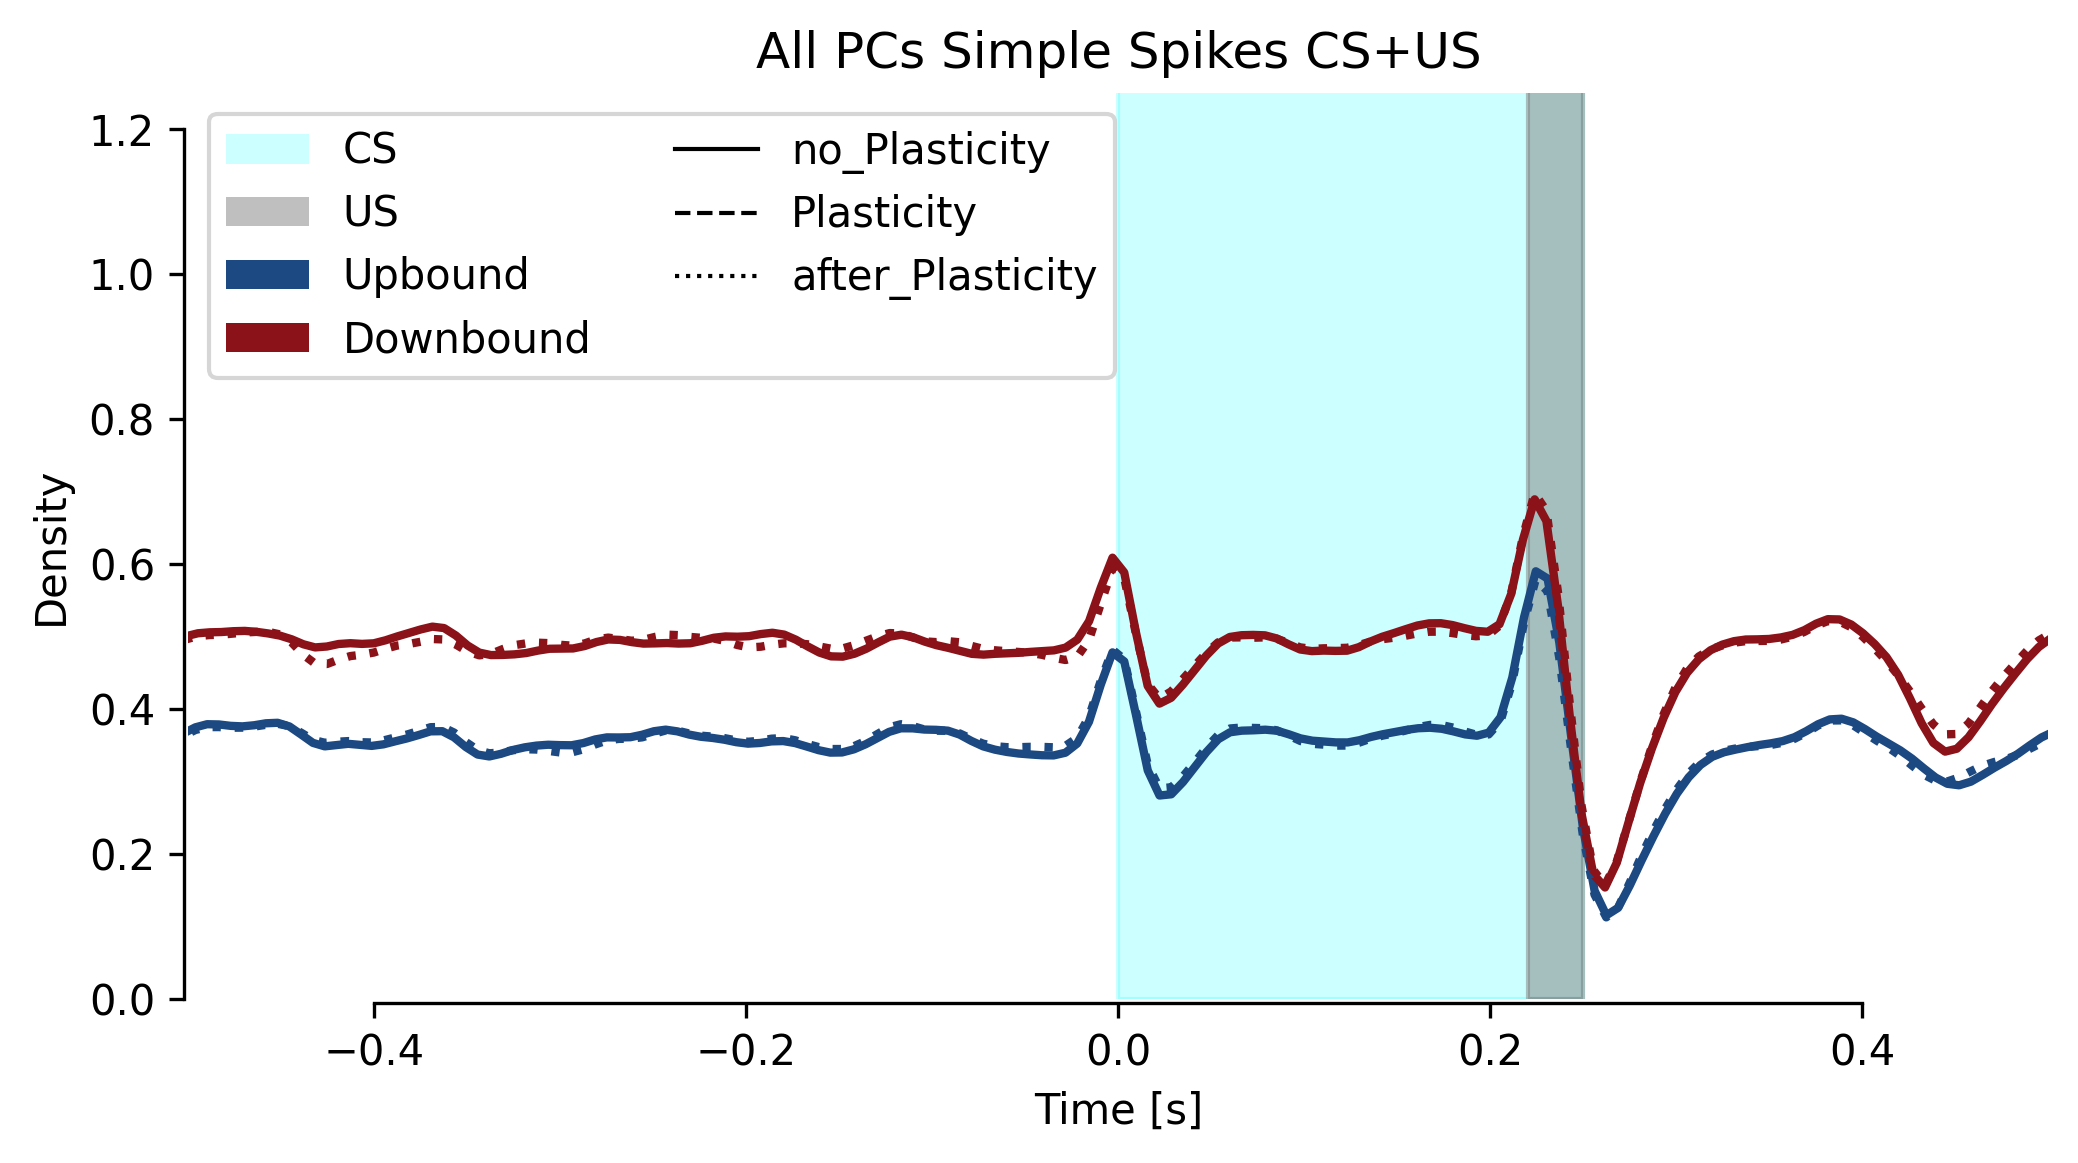

CPU times: user 22.4 s, sys: 19.5 s, total: 41.9 s
Wall time: 1min 1s


In [5]:
%%time
data=[]
plas_rang = ['no_Plasticity']
plas_rang.extend(range_after_plasticity)
step = 0.6
f0_range = [f0]


for seed_number in seed_number_range:
    Noise_sim = Noise_frozen[f'Seed_{seed_number}'].Noise_sim
    iti_arr = Noise_sim['iti_arr_pulse']
    # iti_arr = [10*second]*len(iti_arr)
    iti_arr = iti_arr*second
    iti_arr

    CS_dur = 220*ms
    US_dur = 30*ms
    transient = iti_arr[0]
    ini_US_onset = transient
    ini_US_ofset = transient+US_dur
    CS_onset = [ini_US_ofset+iti_arr[1]]
    US_onset = [CS_onset[0]+CS_dur]
    CS_ofset = [CS_onset[0]+CS_dur+US_dur]
    US_ofset = [US_onset[0]+US_dur]

    for idx,iti in enumerate(iti_arr[2:-1]):
        CS_onset.append(CS_ofset[idx]+iti)
        US_onset.append(US_ofset[idx]+iti+CS_dur)
        CS_ofset.append(CS_ofset[idx]+iti+CS_dur+US_dur)
        US_ofset.append(US_ofset[idx]+iti+CS_dur+US_dur)

    fin_CS_onset = CS_ofset[-1]+iti_arr[-1]
    fin_CS_ofset = fin_CS_onset+CS_dur+US_dur
    for f0 in f0_range[0:1]:
        for zebrin in ['negative','positive']:
            for plasticity in ['no_Plasticity','after_Plasticity']:
                for coupling in ['_Coupled']:
                    PC_output = output_load_run('PC',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                    PC_spikes = output_load_run('PC_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                    for PC_num in range(200):#N_Cells_PC):
                        for stim_time in CS_onset:
                            stim_time=stim_time/second
                            start = int(stim_time*second/dt_rec)-int(step*second/dt_rec)
                            end = int(stim_time*second/dt_rec)+int(step*second/dt_rec)
                            if stim_time < step: continue
                            if stim_time+step > exp_run/second: continue
                            IO_trig_avg = PC_output['v'][PC_num][start:end]/mV*volt
                            arr_PC_spikes = [PC_spikes[f'{PC_num}']]
                            if hasattr(PC_spikes[f'{PC_num}'], "__len__"):
                                arr_PC_spikes = PC_spikes[f'{PC_num}']
                            for io_spike in arr_PC_spikes:
                                if start < io_spike/dt_rec < end:
                                    spike_time = io_spike
                                    corr_spike_time = spike_time - stim_time
                                    row=dict(seed_number=seed_number,cell=PC_num,stimtime=stim_time,spiketime=spike_time,corr_spiketime=corr_spike_time,f0=f0,zebrin=zebrin,plasticity=plasticity,coupling=coupling,IO_trig_avg=IO_trig_avg)
                                    data.append(row)
df_all_PC_onset = pd.DataFrame(data) 


from matplotlib.lines import Line2D
from matplotlib.patches import Patch
coupling = '_Coupled'
ls_p=dict(no_Plasticity='-',Plasticity='--',after_Plasticity=':')
for seed_number in seed_number_range:
    figure(figsize=(8, 4),dpi=300)
    title(f'All PCs Simple Spikes CS+US')
    for plasticity in ['no_Plasticity','after_Plasticity']:
        df_hist = df_all_PC_onset[(df_all_PC_onset['seed_number']==seed_number)&(df_all_PC_onset['plasticity']==plasticity)&(df_all_PC_onset['f0']==f0)&(df_all_PC_onset['coupling']==coupling)]
        aa = sns.kdeplot(data=df_hist, x="corr_spiketime", hue='zebrin',bw_adjust=.3,lw=2,linestyle=ls_p[plasticity],palette={"negative": "#8a1218", "positive": "#1c4981"})#, "after_Plasticity": "r"})
    aa.legend_.remove()
    fill_between([0, 0.25],[0,0],[2,2], color='cyan', alpha=0.2)
    fill_between([0.22, 0.25],[0,0],[2,2], color='grey', alpha=0.5)
    xlim(-0.5,0.5)
    ylim(0,1.25)
    xlabel('Time [s]')
    sns.despine(trim=True,offset=True)

    legend_elements = [Patch(facecolor='cyan', alpha=0.2, label='CS'),
                       Patch(facecolor='grey', alpha=0.5, label='US'),
                       Patch(facecolor='#1c4981', label='Upbound'),
                       Patch(facecolor='#8a1218', label='Downbound'),
                       Line2D([0], [0], linestyle='-', color='k', lw=1, label='no_Plasticity'),
                       Line2D([0], [0], linestyle='--', color='k', lw=1, label='Plasticity'),
                       Line2D([0], [0], linestyle=':', color='k', lw=1, label='after_Plasticity')]
    legend(handles=legend_elements, loc='upper left',ncol=2)
#     plt.savefig(f'{seed_number} SS Spikes CS+US.svg')
    plt.show()


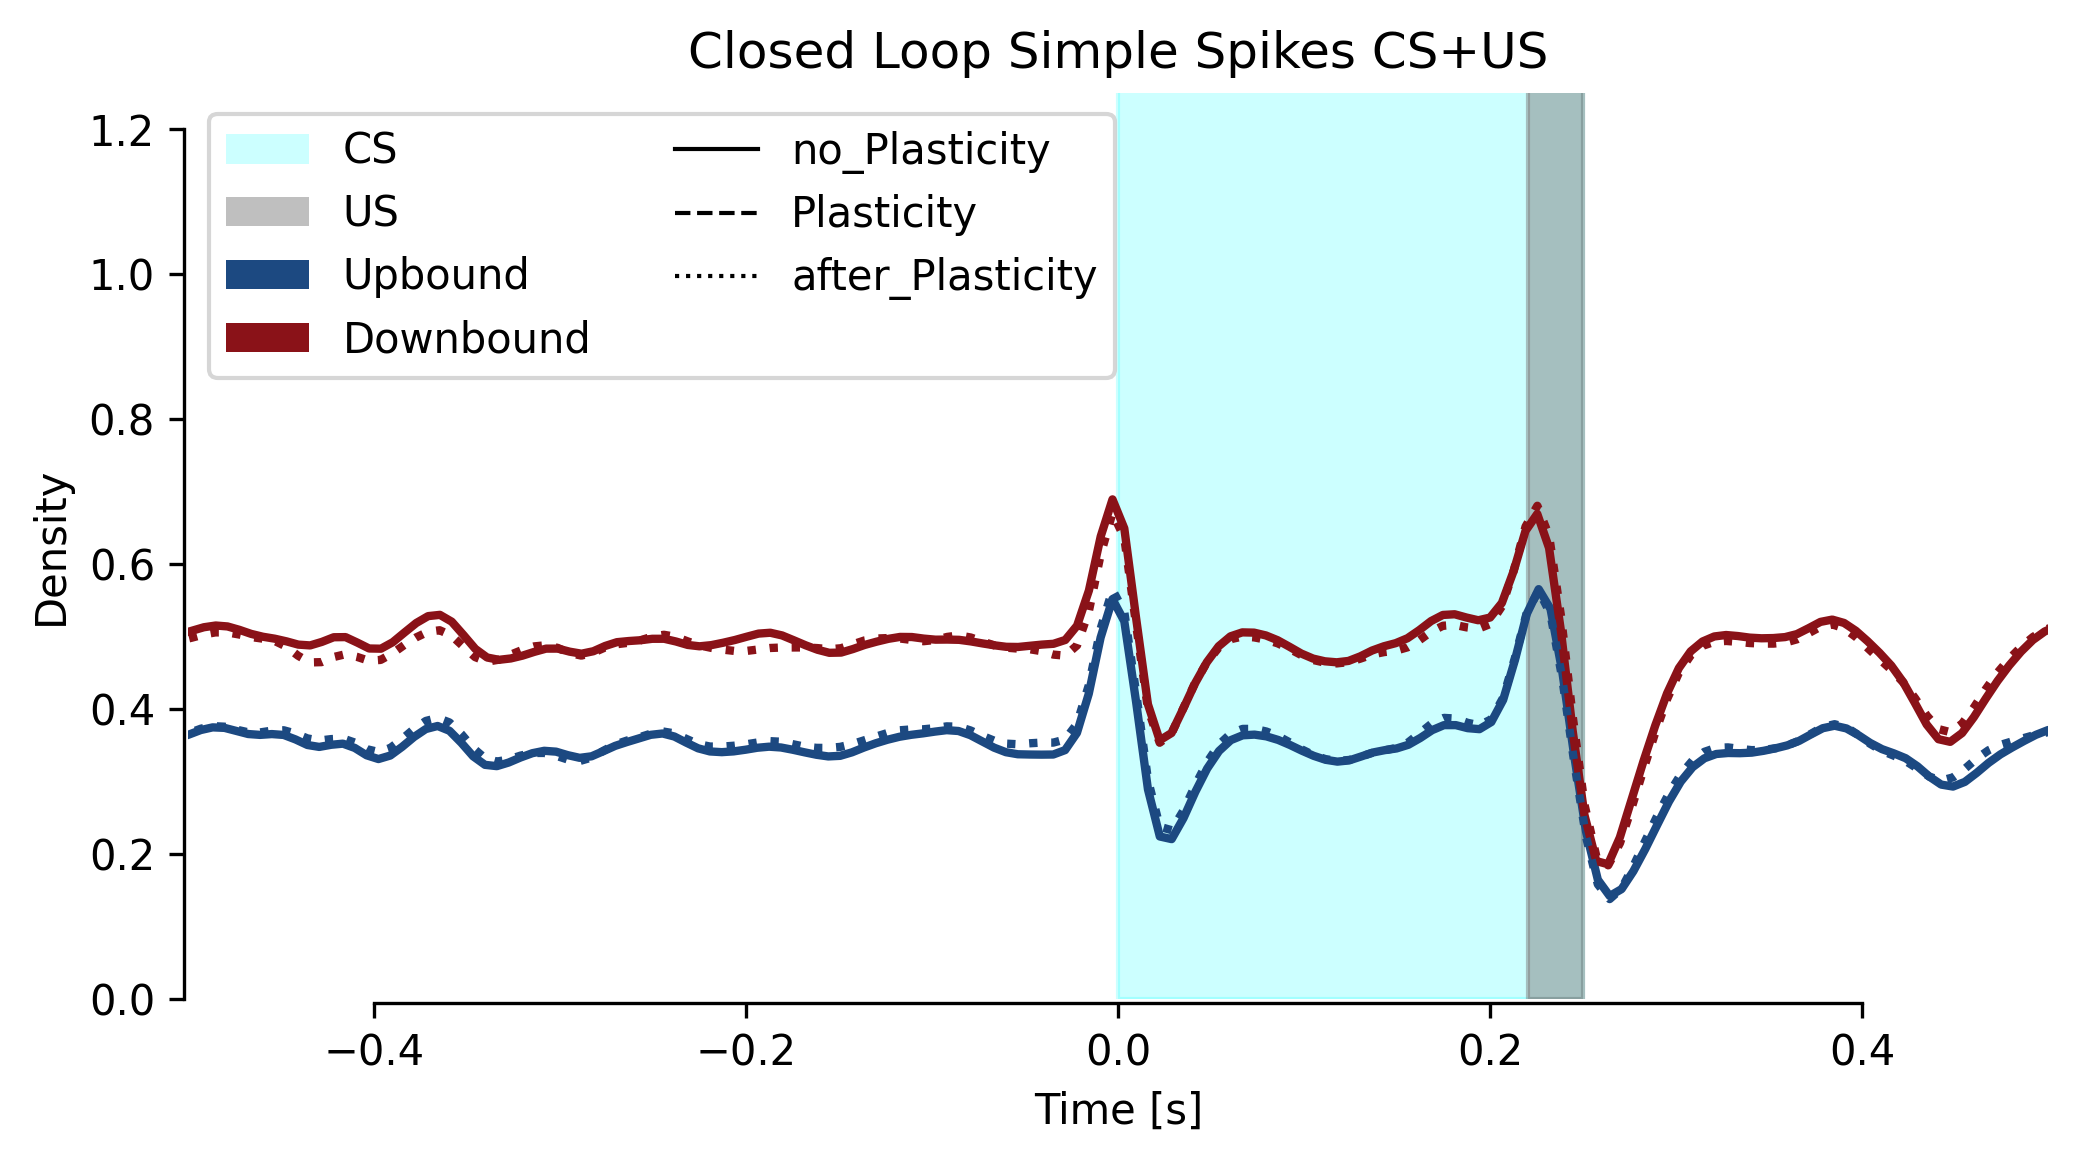

CPU times: user 22.1 s, sys: 24.3 s, total: 46.4 s
Wall time: 1min 43s


In [6]:
%%time
data=[]
plas_rang = ['no_Plasticity']
plas_rang.extend(range_after_plasticity)
step = 0.6
f0_range = [f0]


Noise_sim = Noise_frozen[f'Seed_{seed_number}'].Noise_sim
iti_arr = Noise_sim[f'iti_arr_pulse']
# iti_arr = [10*second]*len(iti_arr)
iti_arr = iti_arr*second
iti_arr

CS_dur = 220*ms
US_dur = 30*ms
transient = iti_arr[0]
ini_US_onset = transient
ini_US_ofset = transient+US_dur
CS_onset = [ini_US_ofset+iti_arr[1]]
US_onset = [CS_onset[0]+CS_dur]
CS_ofset = [CS_onset[0]+CS_dur+US_dur]
US_ofset = [US_onset[0]+US_dur]

for idx,iti in enumerate(iti_arr[2:-1]):
    CS_onset.append(CS_ofset[idx]+iti)
    US_onset.append(US_ofset[idx]+iti+CS_dur)
    CS_ofset.append(CS_ofset[idx]+iti+CS_dur+US_dur)
    US_ofset.append(US_ofset[idx]+iti+CS_dur+US_dur)

fin_CS_onset = CS_ofset[-1]+iti_arr[-1]
fin_CS_ofset = fin_CS_onset+CS_dur+US_dur
for f0 in f0_range[0:1]:
    for zebrin in ['negative','positive']:
        for plasticity in ['no_Plasticity','after_Plasticity']:
            for coupling in ['_Coupled','']:
                PC_output = output_load_run('PC',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                PC_spikes = output_load_run('PC_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for PC_num in range(100):#N_Cells_PC):
                    for stim_time in CS_onset:
                        stim_time=stim_time/second
                        start = int(stim_time*second/dt_rec)-int(step*second/dt_rec)
                        end = int(stim_time*second/dt_rec)+int(step*second/dt_rec)
                        if stim_time < step: continue
                        if stim_time+step > exp_run/second: continue
                        IO_trig_avg = PC_output['v'][PC_num][start:end]/mV*volt
                        arr_PC_spikes = [PC_spikes[f'{PC_num}']]
                        if hasattr(PC_spikes[f'{PC_num}'], "__len__"):
                            arr_PC_spikes = PC_spikes[f'{PC_num}']
                        for io_spike in arr_PC_spikes:
                            if start < io_spike/dt_rec < end:
                                spike_time = io_spike
                                corr_spike_time = spike_time - stim_time
                                row=dict(seed_number=seed_number,cell=PC_num,stimtime=stim_time,spiketime=spike_time,corr_spiketime=corr_spike_time,f0=f0,zebrin=zebrin,plasticity=plasticity,coupling=coupling,IO_trig_avg=IO_trig_avg)
                                data.append(row)
df_all_PC_onset = pd.DataFrame(data) 

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
coupling = '_Coupled'
ls_p=dict(no_Plasticity='-',Plasticity='--',after_Plasticity=':')
for seed_number in seed_number_range:
    figure(figsize=(8, 4),dpi=300)
    title(f'Closed Loop Simple Spikes CS+US')
    for plasticity in ['no_Plasticity','after_Plasticity']:
        df_hist = df_all_PC_onset[(df_all_PC_onset['seed_number']==seed_number)&(df_all_PC_onset['plasticity']==plasticity)&(df_all_PC_onset['f0']==f0)&(df_all_PC_onset['coupling']==coupling)]
        aa = sns.kdeplot(data=df_hist, x="corr_spiketime", hue='zebrin',bw_adjust=.3,lw=2,linestyle=ls_p[plasticity],palette={"negative": "#8a1218", "positive": "#1c4981"})#, "after_Plasticity": "r"})
    aa.legend_.remove()
    fill_between([0, 0.25],[0,0],[2,2], color='cyan', alpha=0.2)
    fill_between([0.22, 0.25],[0,0],[2,2], color='grey', alpha=0.5)
    xlim(-0.5,0.5)
    ylim(0,1.25)
    xlabel('Time [s]')
    sns.despine(trim=True,offset=True)

    legend_elements = [Patch(facecolor='cyan', alpha=0.2, label='CS'),
                       Patch(facecolor='grey', alpha=0.5, label='US'),
                       Patch(facecolor='#1c4981', label='Upbound'),
                       Patch(facecolor='#8a1218', label='Downbound'),
                       Line2D([0], [0], linestyle='-', color='k', lw=1, label='no_Plasticity'),
                       Line2D([0], [0], linestyle='--', color='k', lw=1, label='Plasticity'),
                       Line2D([0], [0], linestyle=':', color='k', lw=1, label='after_Plasticity')]
    legend(handles=legend_elements, loc='upper left',ncol=2)
#     plt.savefig(f'{seed_number} SS Spikes CS+US.svg')
    plt.show()


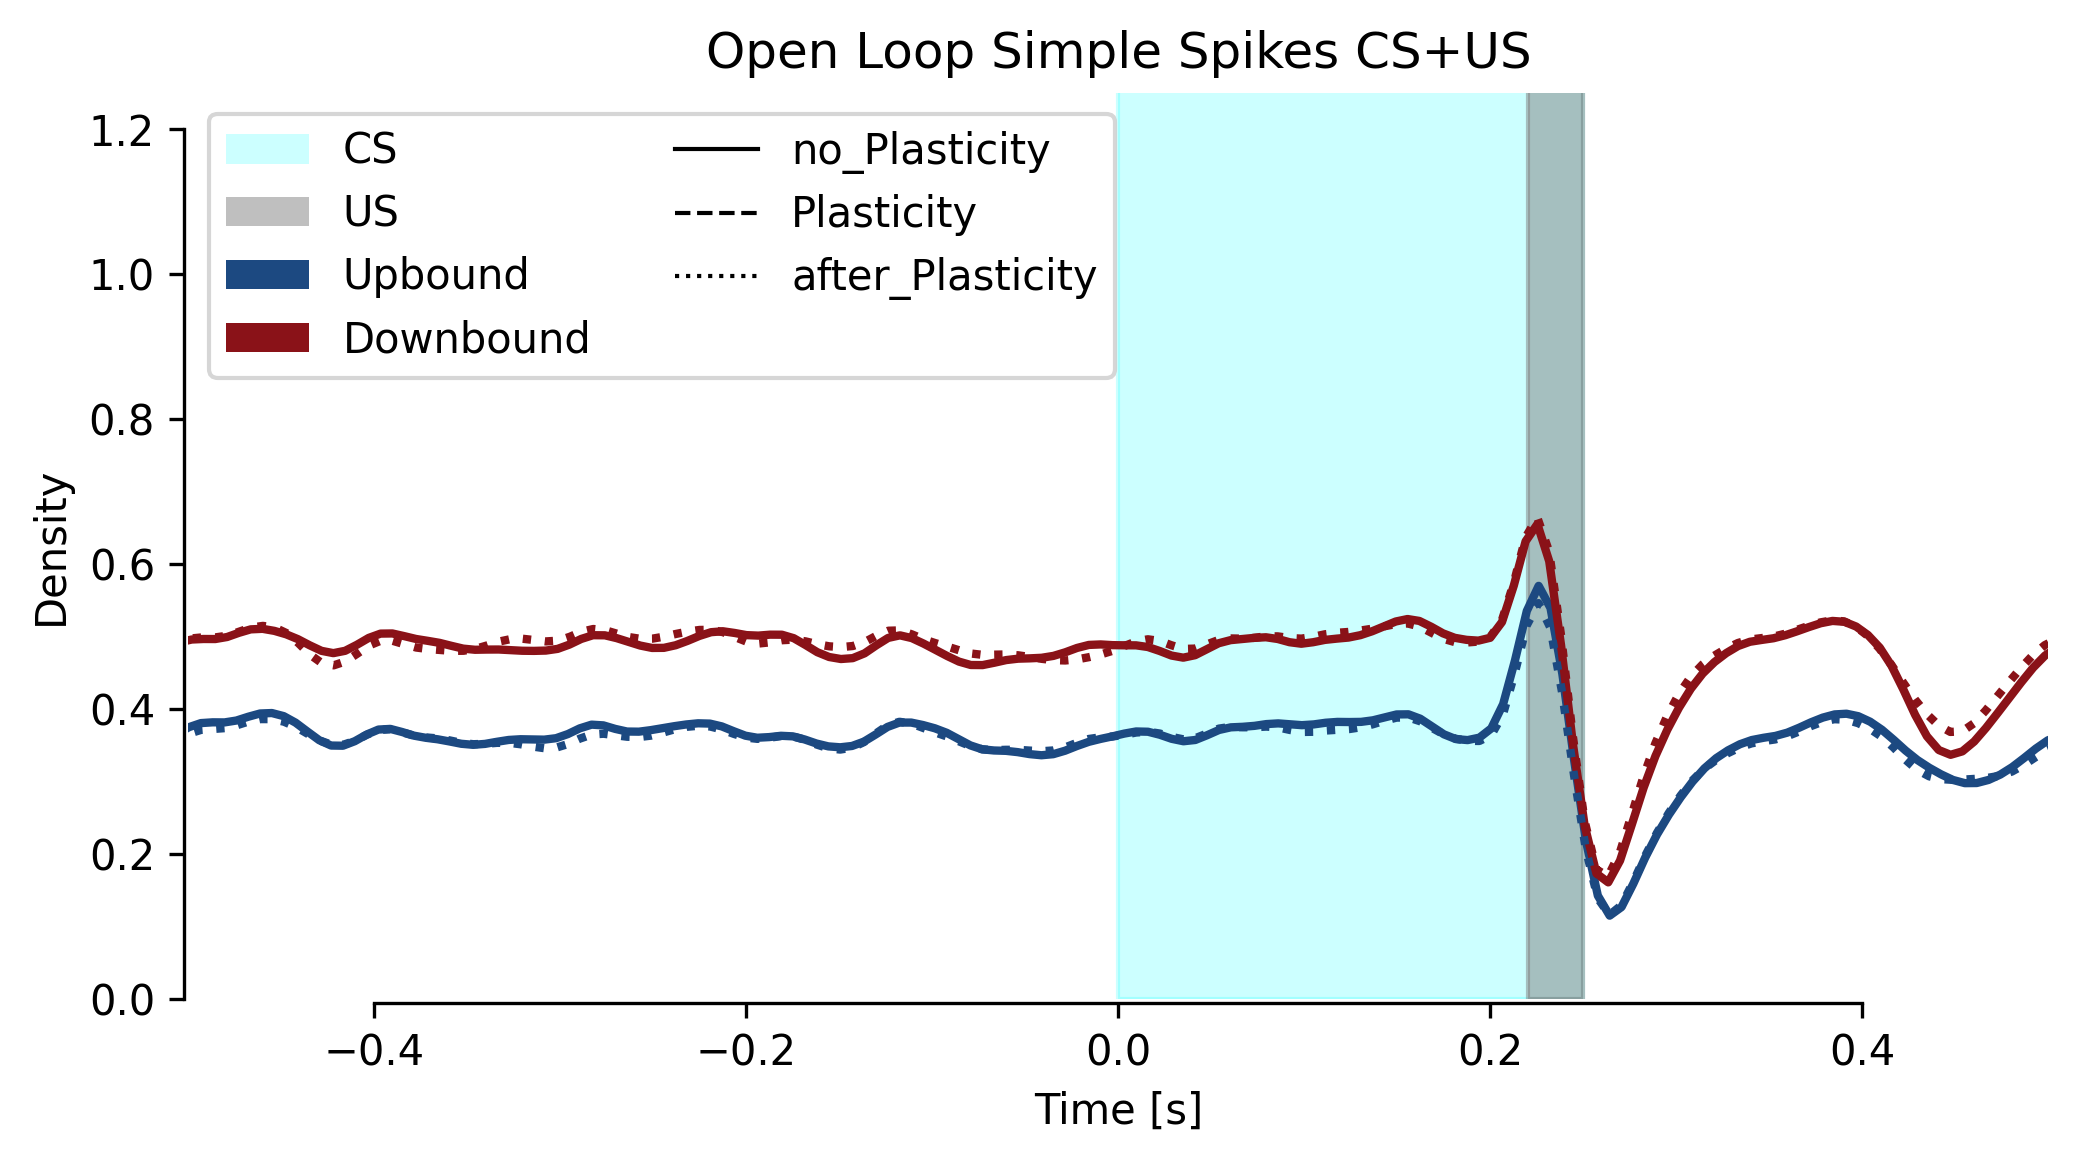

CPU times: user 13.7 s, sys: 19.7 s, total: 33.4 s
Wall time: 52.5 s


In [7]:
%%time
data=[]
plas_rang = ['no_Plasticity']
plas_rang.extend(range_after_plasticity)
step = 0.6
f0_range = [f0]


for seed_number in seed_number_range:
    Noise_sim = Noise_frozen[f'Seed_{seed_number}'].Noise_sim
    iti_arr = Noise_sim['iti_arr_pulse']
    # iti_arr = [10*second]*len(iti_arr)
    iti_arr = iti_arr*second
    iti_arr

    CS_dur = 220*ms
    US_dur = 30*ms
    transient = iti_arr[0]
    ini_US_onset = transient
    ini_US_ofset = transient+US_dur
    CS_onset = [ini_US_ofset+iti_arr[1]]
    US_onset = [CS_onset[0]+CS_dur]
    CS_ofset = [CS_onset[0]+CS_dur+US_dur]
    US_ofset = [US_onset[0]+US_dur]

    for idx,iti in enumerate(iti_arr[2:-1]):
        CS_onset.append(CS_ofset[idx]+iti)
        US_onset.append(US_ofset[idx]+iti+CS_dur)
        CS_ofset.append(CS_ofset[idx]+iti+CS_dur+US_dur)
        US_ofset.append(US_ofset[idx]+iti+CS_dur+US_dur)

    fin_CS_onset = CS_ofset[-1]+iti_arr[-1]
    fin_CS_ofset = fin_CS_onset+CS_dur+US_dur
    for f0 in f0_range[0:1]:
        for zebrin in ['negative','positive']:
            for plasticity in ['no_Plasticity','after_Plasticity']:
                for coupling in ['_Coupled']:
                    PC_output = output_load_run('PC',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                    PC_spikes = output_load_run('PC_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                    for PC_num in range(100,200):#N_Cells_PC):
                        for stim_time in CS_onset:
                            stim_time=stim_time/second
                            start = int(stim_time*second/dt_rec)-int(step*second/dt_rec)
                            end = int(stim_time*second/dt_rec)+int(step*second/dt_rec)
                            if stim_time < step: continue
                            if stim_time+step > exp_run/second: continue
                            IO_trig_avg = PC_output['v'][PC_num][start:end]/mV*volt
                            arr_PC_spikes = [PC_spikes[f'{PC_num}']]
                            if hasattr(PC_spikes[f'{PC_num}'], "__len__"):
                                arr_PC_spikes = PC_spikes[f'{PC_num}']
                            for io_spike in arr_PC_spikes:
                                if start < io_spike/dt_rec < end:
                                    spike_time = io_spike
                                    corr_spike_time = spike_time - stim_time
                                    row=dict(seed_number=seed_number,cell=PC_num,stimtime=stim_time,spiketime=spike_time,corr_spiketime=corr_spike_time,f0=f0,zebrin=zebrin,plasticity=plasticity,coupling=coupling,IO_trig_avg=IO_trig_avg)
                                    data.append(row)
df_all_PC_onset = pd.DataFrame(data) 


from matplotlib.lines import Line2D
from matplotlib.patches import Patch
coupling = '_Coupled'
ls_p=dict(no_Plasticity='-',Plasticity='--',after_Plasticity=':')
for seed_number in seed_number_range:
    figure(figsize=(8, 4),dpi=300)
    title(f'Open Loop Simple Spikes CS+US')
    for plasticity in ['no_Plasticity','after_Plasticity']:
        df_hist = df_all_PC_onset[(df_all_PC_onset['seed_number']==seed_number)&(df_all_PC_onset['plasticity']==plasticity)&(df_all_PC_onset['f0']==f0)&(df_all_PC_onset['coupling']==coupling)]
        aa = sns.kdeplot(data=df_hist, x="corr_spiketime", hue='zebrin',bw_adjust=.3,lw=2,linestyle=ls_p[plasticity],palette={"negative": "#8a1218", "positive": "#1c4981"})#, "after_Plasticity": "r"})
    aa.legend_.remove()
    fill_between([0, 0.25],[0,0],[2,2], color='cyan', alpha=0.2)
    fill_between([0.22, 0.25],[0,0],[2,2], color='grey', alpha=0.5)
    xlim(-0.5,0.5)
    ylim(0,1.25)
    xlabel('Time [s]')
    sns.despine(trim=True,offset=True)

    legend_elements = [Patch(facecolor='cyan', alpha=0.2, label='CS'),
                       Patch(facecolor='grey', alpha=0.5, label='US'),
                       Patch(facecolor='#1c4981', label='Upbound'),
                       Patch(facecolor='#8a1218', label='Downbound'),
                       Line2D([0], [0], linestyle='-', color='k', lw=1, label='no_Plasticity'),
                       Line2D([0], [0], linestyle='--', color='k', lw=1, label='Plasticity'),
                       Line2D([0], [0], linestyle=':', color='k', lw=1, label='after_Plasticity')]
    legend(handles=legend_elements, loc='upper left',ncol=2)
#     plt.savefig(f'{seed_number} SS Spikes CS+US.svg')
    plt.show()


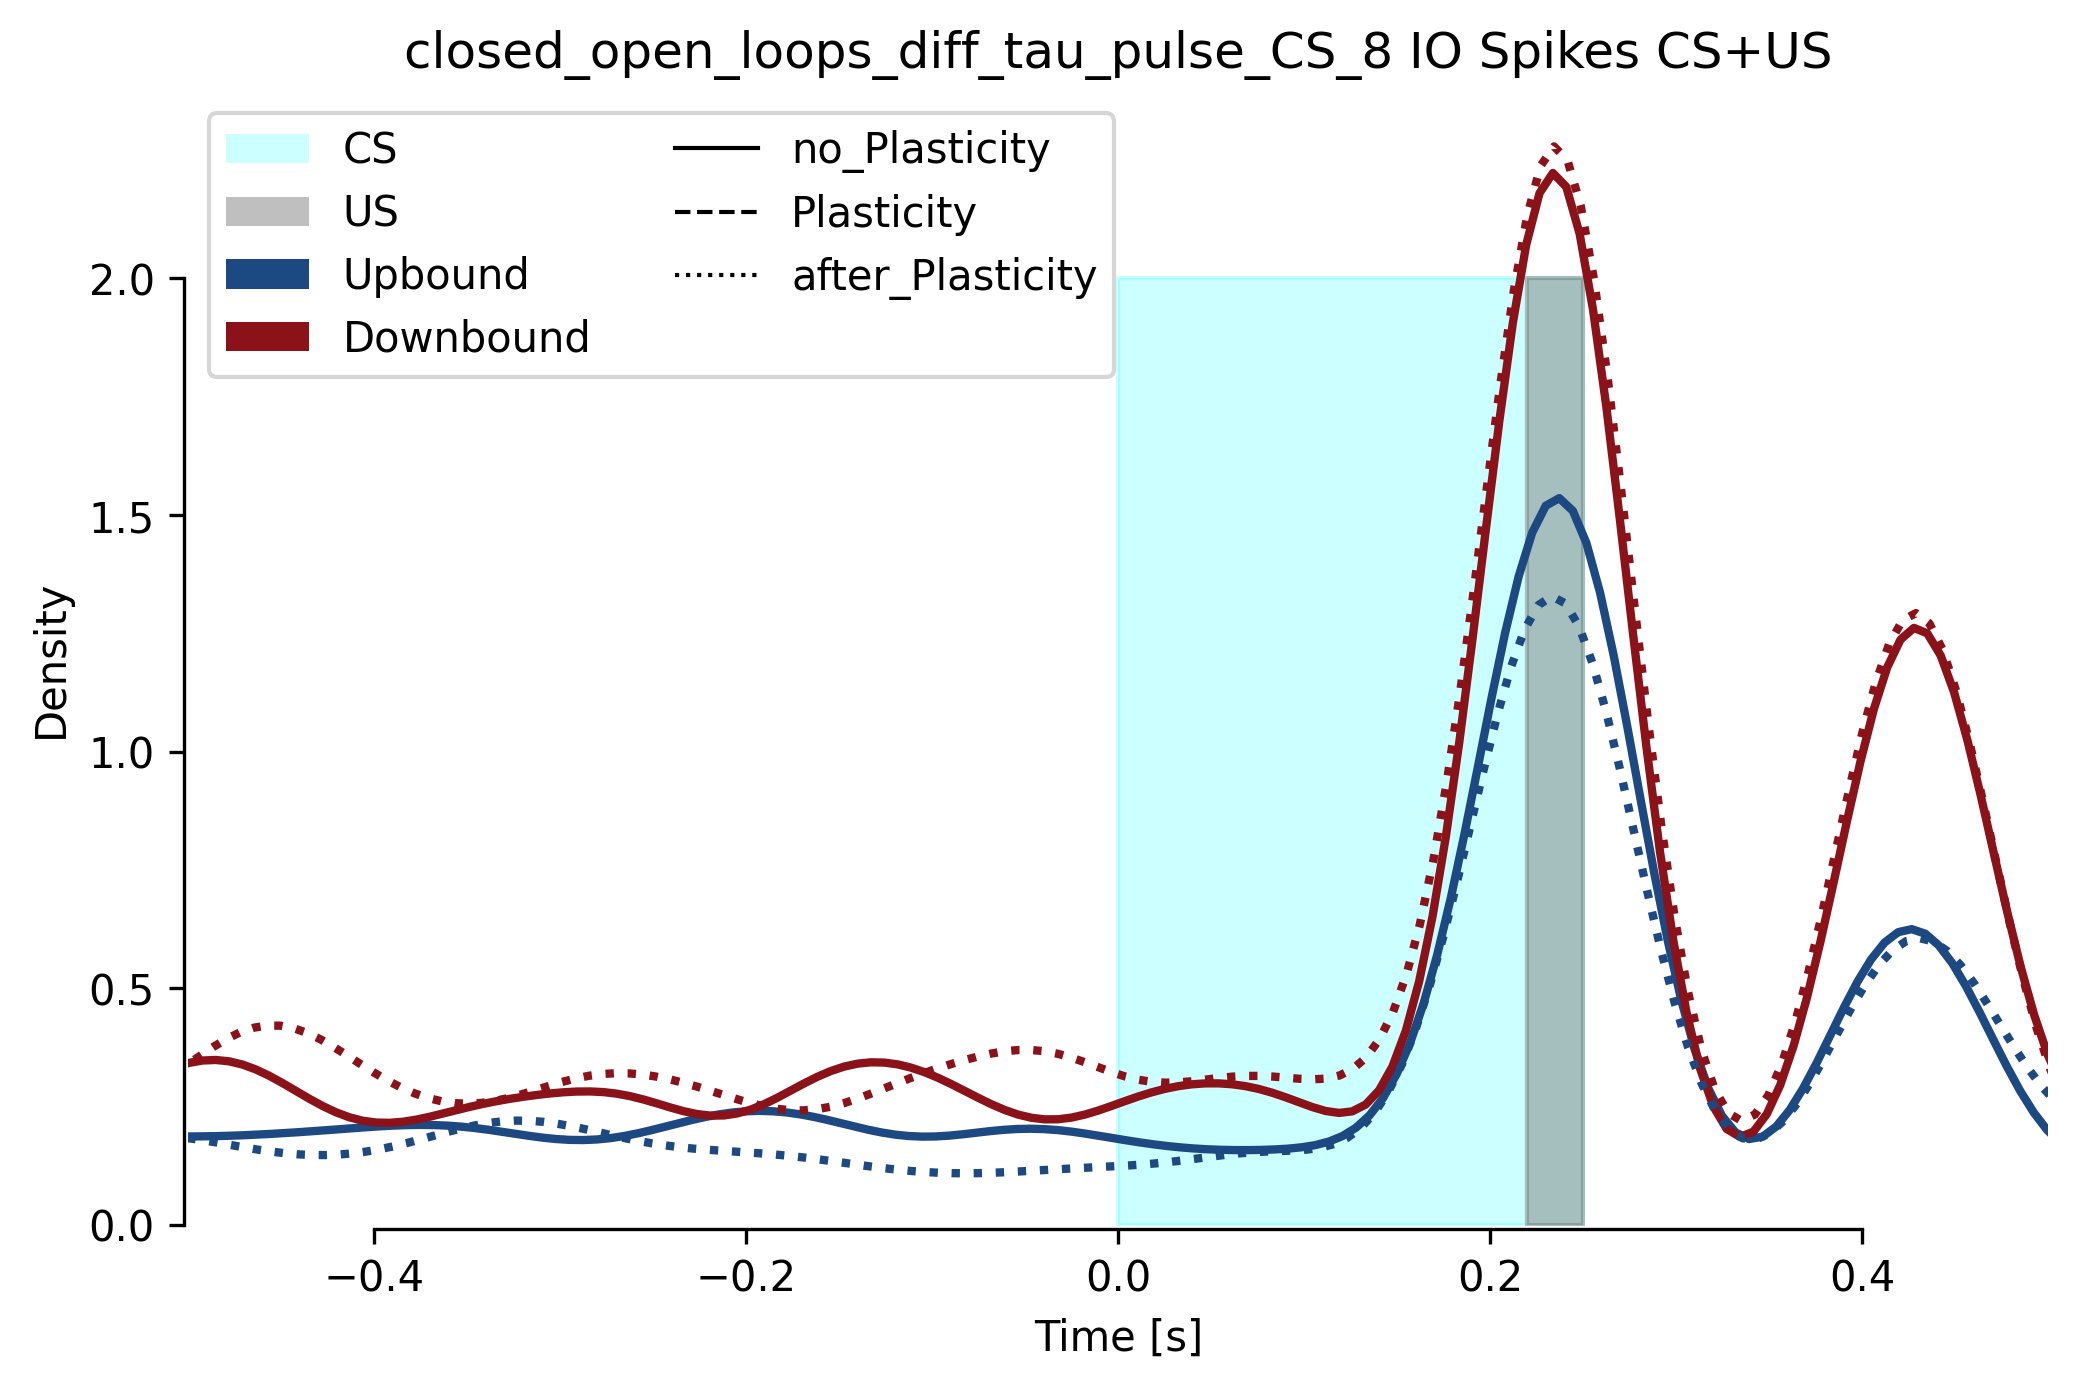

CPU times: user 2.44 s, sys: 6.96 s, total: 9.4 s
Wall time: 29.1 s


In [8]:
%%time
data=[]
plas_rang = ['no_Plasticity']
plas_rang.extend(range_after_plasticity)
step = 0.6
f0_range = [f0]


for seed_number in seed_number_range:
    Noise_sim = Noise_frozen[f'Seed_{seed_number}'].Noise_sim
    iti_arr = Noise_sim['iti_arr_pulse']
    # iti_arr = [10*second]*len(iti_arr)
    iti_arr = iti_arr*second
    iti_arr

    CS_dur = 220*ms
    US_dur = 30*ms
    transient = iti_arr[0]
    ini_US_onset = transient
    ini_US_ofset = transient+US_dur
    CS_onset = [ini_US_ofset+iti_arr[1]]
    US_onset = [CS_onset[0]+CS_dur]
    CS_ofset = [CS_onset[0]+CS_dur+US_dur]
    US_ofset = [US_onset[0]+US_dur]

    for idx,iti in enumerate(iti_arr[2:-1]):
        CS_onset.append(CS_ofset[idx]+iti)
        US_onset.append(US_ofset[idx]+iti+CS_dur)
        CS_ofset.append(CS_ofset[idx]+iti+CS_dur+US_dur)
        US_ofset.append(US_ofset[idx]+iti+CS_dur+US_dur)

    fin_CS_onset = CS_ofset[-1]+iti_arr[-1]
    fin_CS_ofset = fin_CS_onset+CS_dur+US_dur
    for f0 in f0_range[0:1]:
        for zebrin in ['negative','positive']:
            for plasticity in plasticity_range:#['no_Plasticity','after_Plasticity']:
                for coupling in ['_Coupled','']:
                    IO_output = output_load_run('IO',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                    IO_spikes = output_load_run('IO_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                    for io_num in range(N_Cells_IO):
                        for stim_time in CS_onset:
                            stim_time=stim_time/second
                            start = int(stim_time*second/dt_rec)-int(step*second/dt_rec)
                            end = int(stim_time*second/dt_rec)+int(step*second/dt_rec)
                            if stim_time < step: continue
                            if stim_time+step > exp_run/second: continue
                            IO_trig_avg = IO_output['Vs'][io_num][start:end]/mV*volt
                            for io_spike in IO_spikes[f'{io_num}']:
                                if start < io_spike/dt_rec < end:
                                    spike_time = io_spike
                                    corr_spike_time = spike_time - stim_time
                                    row=dict(seed_number=seed_number,cell=io_num,stimtime=stim_time,spiketime=spike_time,corr_spiketime=corr_spike_time,f0=f0,zebrin=zebrin,plasticity=plasticity,coupling=coupling,IO_trig_avg=IO_trig_avg)
                                    data.append(row)
df_all_IO_onset = pd.DataFrame(data) 

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
coupling = '_Coupled'
ls_p=dict(no_Plasticity='-',Plasticity='--',after_Plasticity=':')
for seed_number in seed_number_range:
    figure(figsize=(8, 5),dpi=300)
    title(f'{seed_number} IO Spikes CS+US')
    for plasticity in ['no_Plasticity','after_Plasticity']:
        df_hist = df_all_IO_onset[(df_all_IO_onset['seed_number']==seed_number)&(df_all_IO_onset['plasticity']==plasticity)&(df_all_IO_onset['f0']==f0)&(df_all_IO_onset['coupling']==coupling)] 
        aa = sns.kdeplot(data=df_hist, x="corr_spiketime", hue='zebrin',bw_adjust=.5,lw=2,linestyle=ls_p[plasticity],palette={"negative": "#8a1218", "positive": "#1c4981"})#, "after_Plasticity": "r"})
    aa.legend_.remove()
    fill_between([0, 0.25],[0,0],[2,2], color='cyan', alpha=0.2)
    fill_between([0.22, 0.25],[0,0],[2,2], color='grey', alpha=0.5)
    xlim(-0.5,0.5)
#     ylim(0,1)
    xlabel('Time [s]')
    sns.despine(trim=True,offset=True)

    legend_elements = [Patch(facecolor='cyan', alpha=0.2, label='CS'),
                       Patch(facecolor='grey', alpha=0.5, label='US'),
                       Patch(facecolor='#1c4981', label='Upbound'),
                       Patch(facecolor='#8a1218', label='Downbound'),
                       Line2D([0], [0], linestyle='-', color='k', lw=1, label='no_Plasticity'),
                       Line2D([0], [0], linestyle='--', color='k', lw=1, label='Plasticity'),
                       Line2D([0], [0], linestyle=':', color='k', lw=1, label='after_Plasticity')]
    legend(handles=legend_elements, loc='upper left',ncol=2)
#     plt.savefig(f'{seed_number} IO Spikes CS+US.svg')
    plt.show()


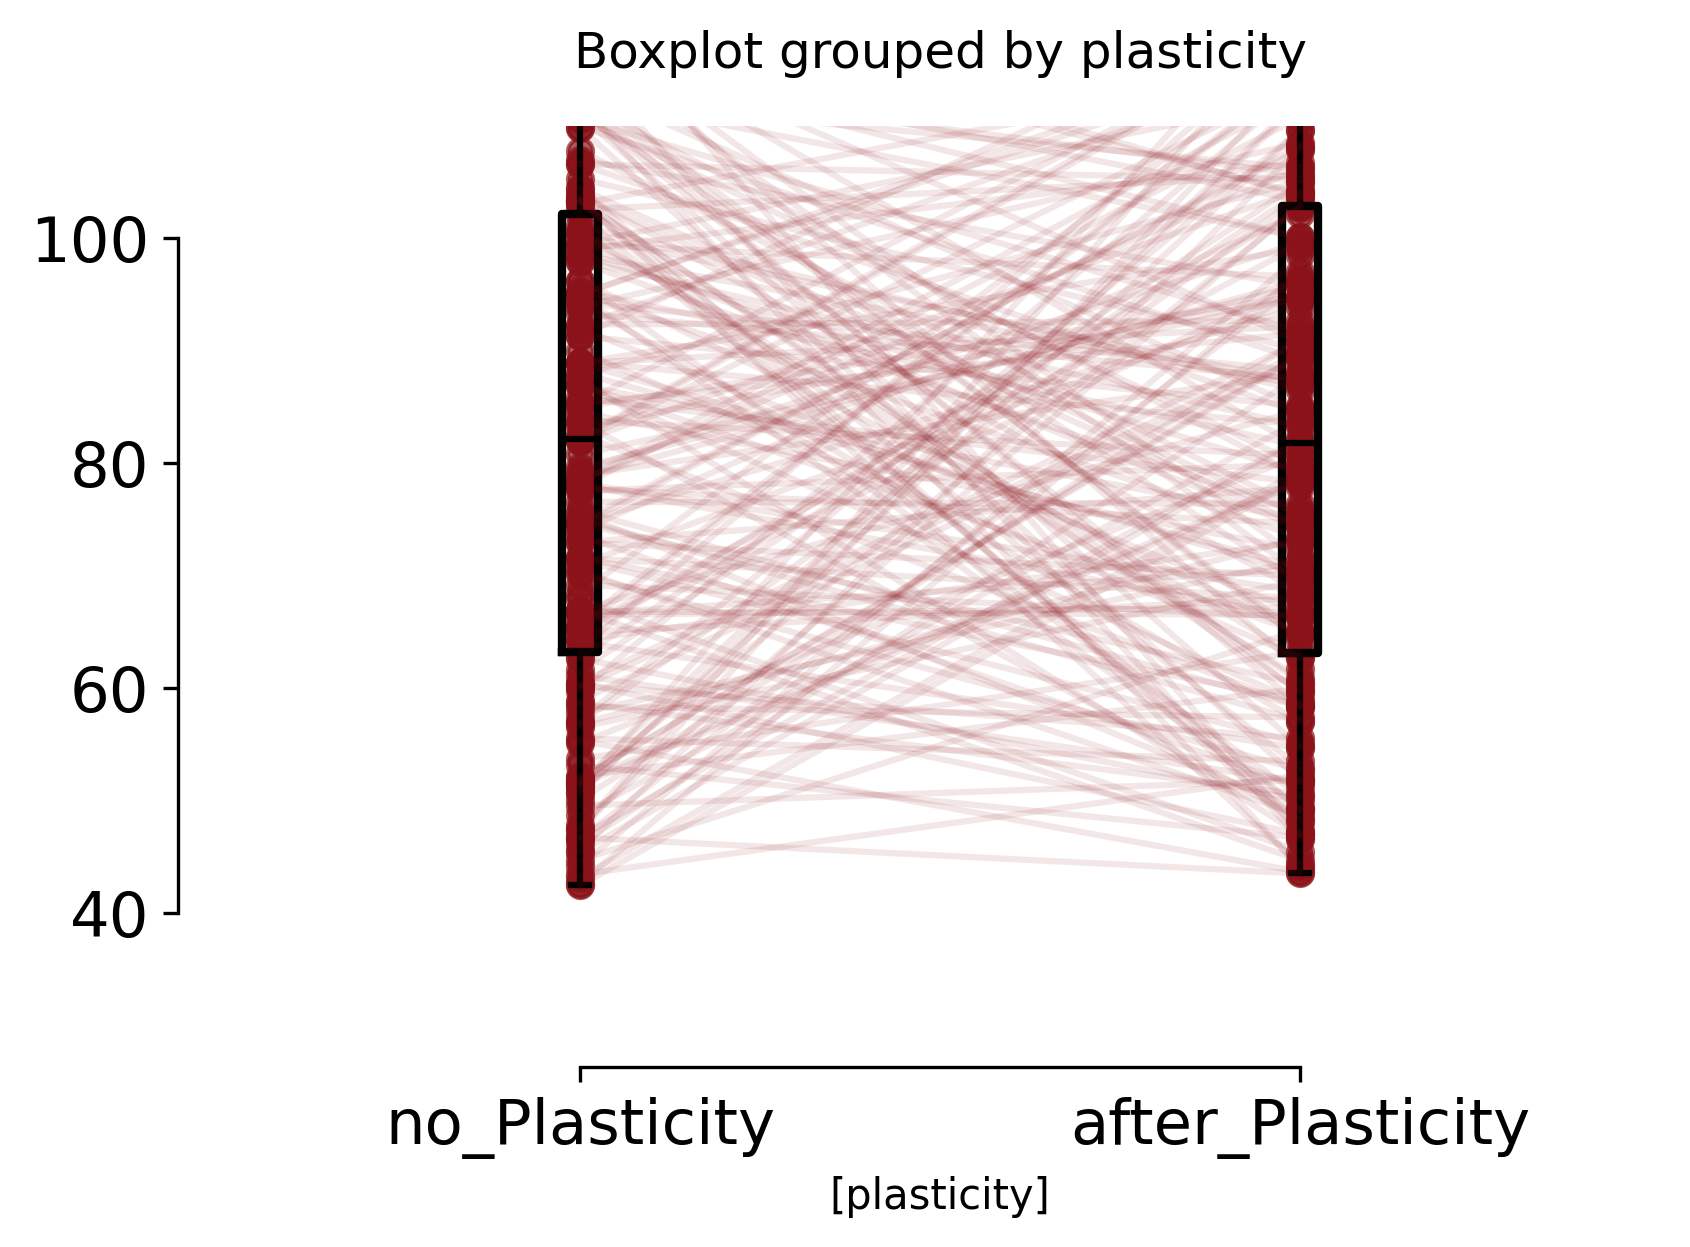

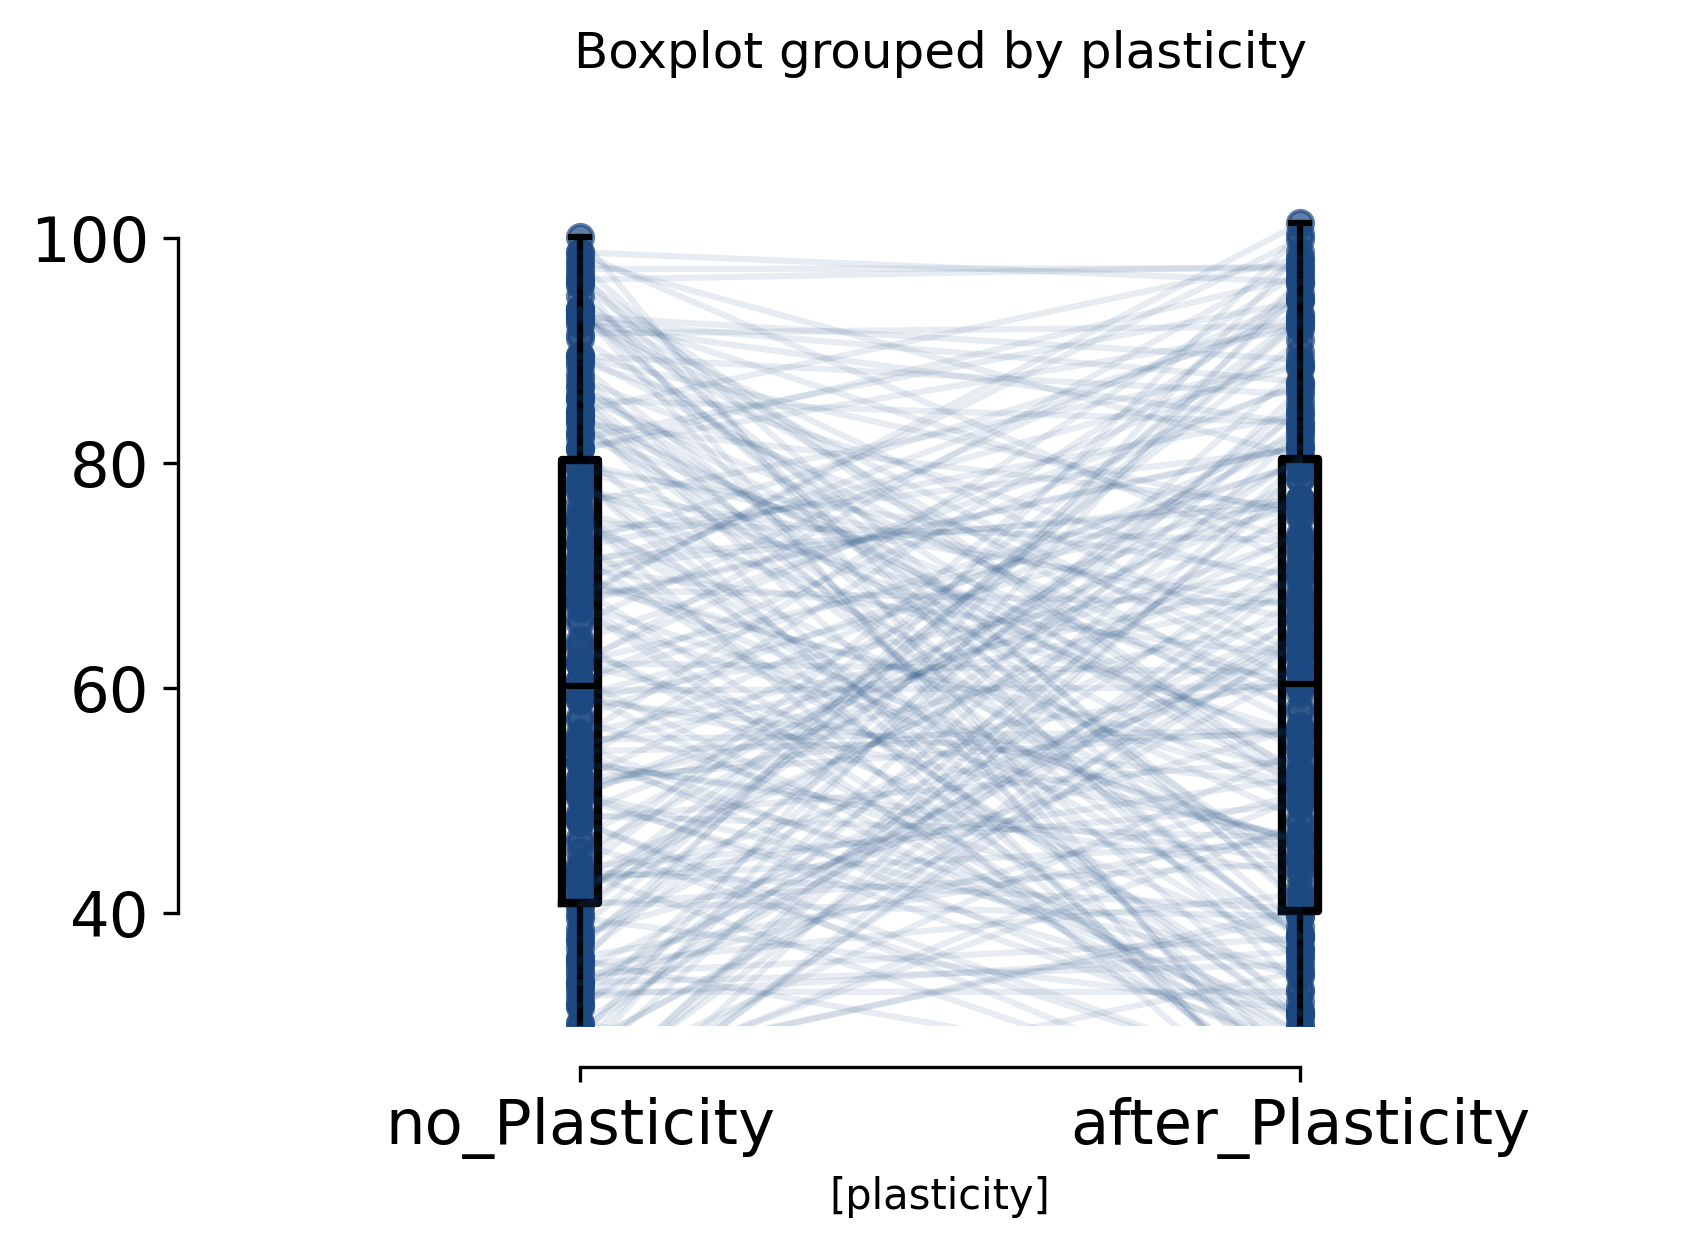

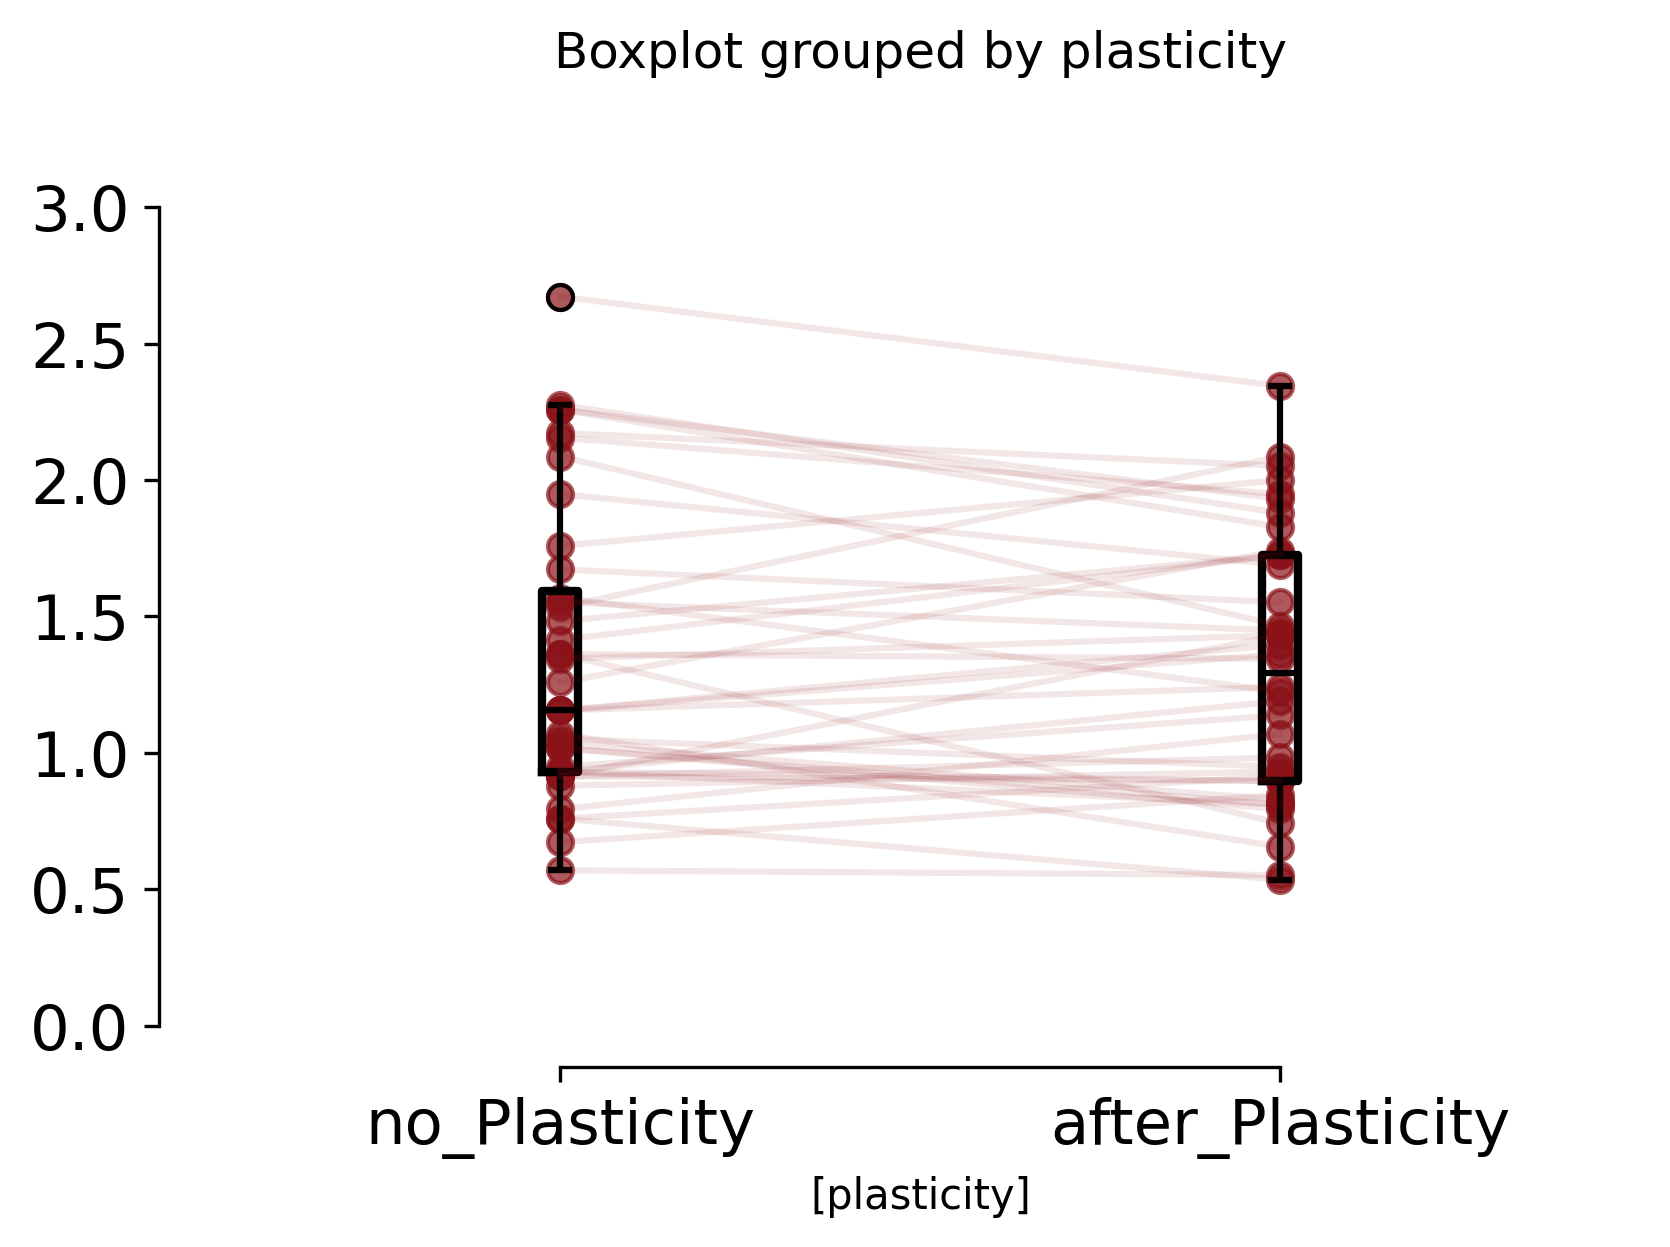

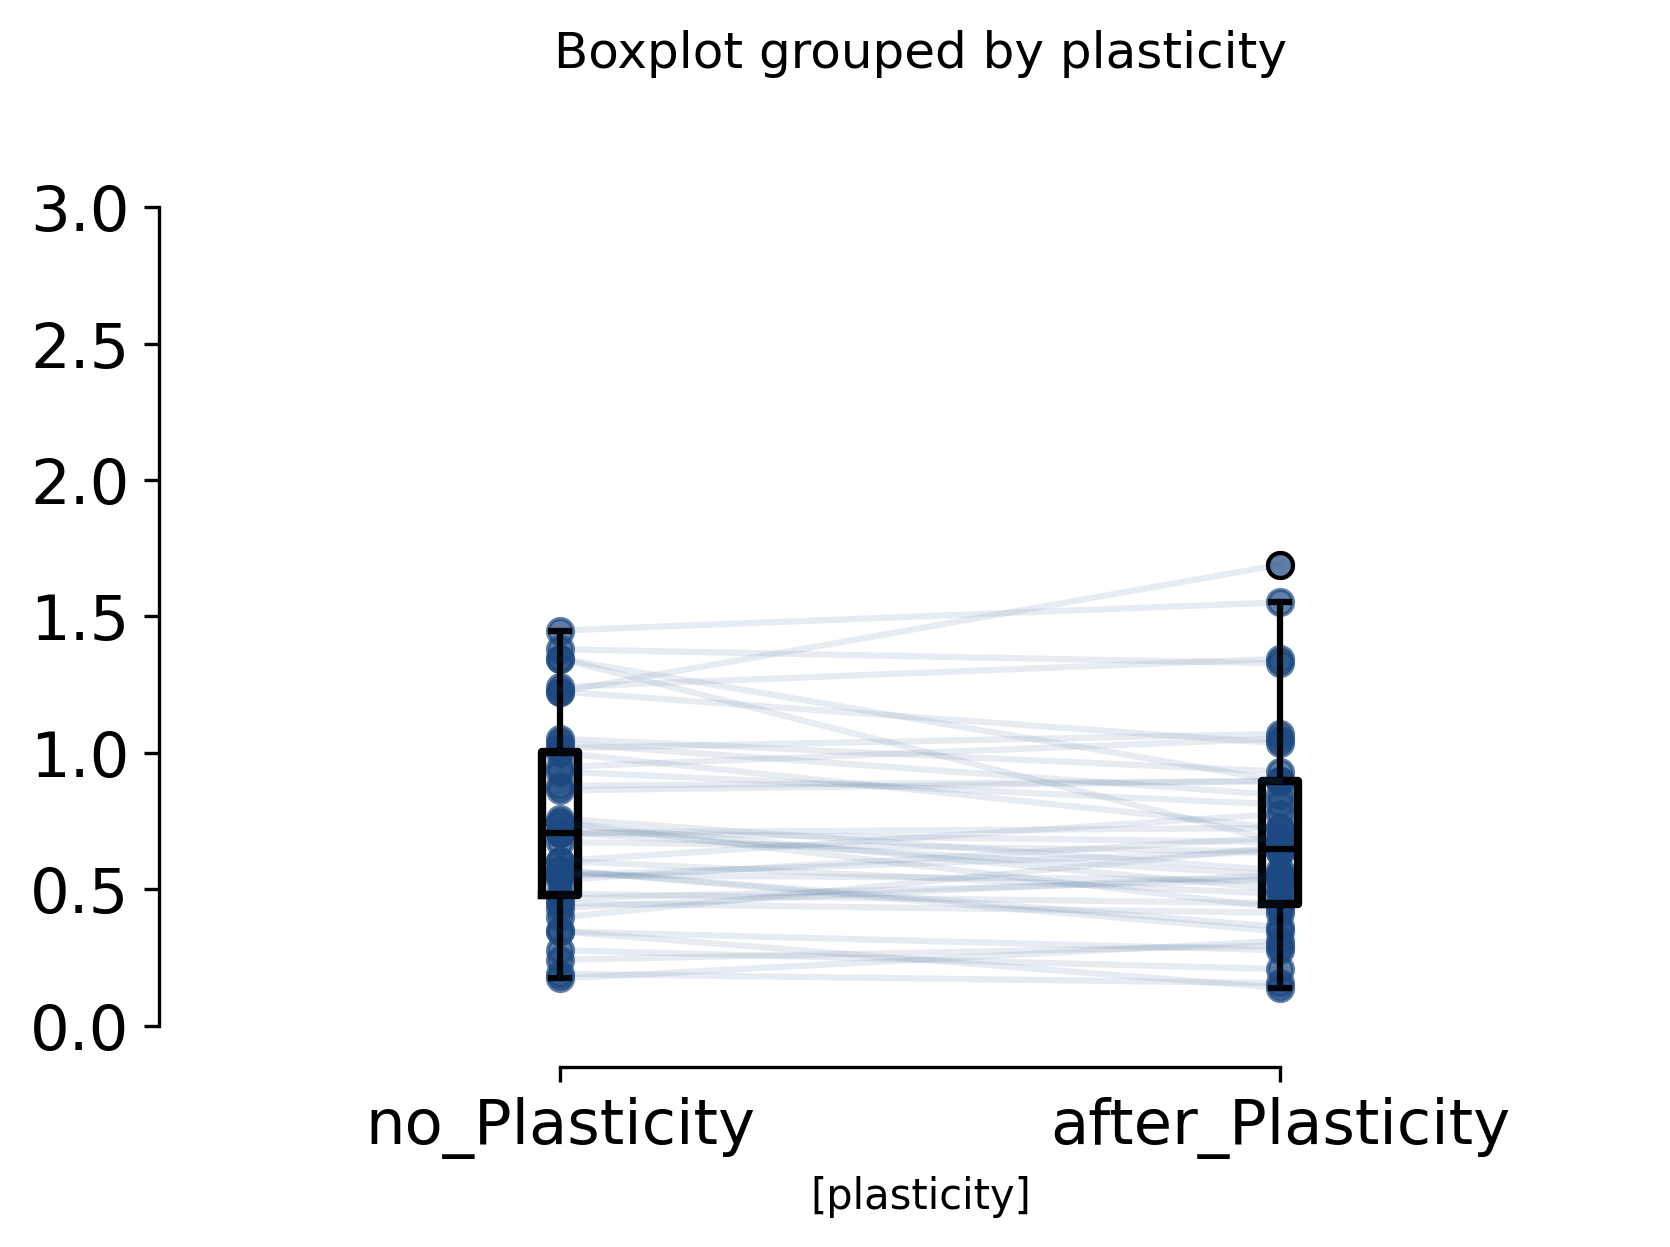

CPU times: user 1.36 s, sys: 518 ms, total: 1.88 s
Wall time: 2.36 s


In [9]:
%%time
t_start = 1 * second
t_stop = 59 * second
bin_size = 1 * second
coupling = '_Coupled'

cell_pop_sizes = dict(PC=N_Cells_PC,IO=N_Cells_IO,DCN=N_Cells_DCN)
colors = dict(positive='#1c4981',negative='#8a1218')
names = {}
for plasticity in plasticity_range:
    if plasticity == 'no_Plasticity': names[f'{plasticity}'] = 'NP'
    elif plasticity == 'Plasticity': names[f'{plasticity}'] = 'P1'
    elif plasticity == 'Plasticity2': names[f'{plasticity}'] = 'P2'
    elif plasticity == 'Plasticity3': names[f'{plasticity}'] = 'P3'
    elif plasticity == 'Plasticity4': names[f'{plasticity}'] = 'P4'
    elif plasticity == 'after_Plasticity': names[f'{plasticity}'] = 'AP1'
    elif plasticity == 'after_Plasticity2': names[f'{plasticity}'] = 'AP2'
    elif plasticity == 'after_Plasticity3': names[f'{plasticity}'] = 'AP3'
    elif plasticity == 'after_Plasticity4': names[f'{plasticity}'] = 'AP4'
        
data = []
for coupling in (['', '_Coupled']):
    for cell_name in ['PC','IO']:
        for zebrin in zebrin_range:
            for order,plasticity in enumerate(['after_Plasticity','no_Plasticity']):
                spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for cell_num in range(cell_pop_sizes[cell_name]):
                    spikes = spikes_output[f'{cell_num}']
                    bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
                    spike_counts, _ = np.histogram(spikes, bins=bin_edges)
                    mean_count = spike_counts / bin_size
                    row = dict(frequency = mean(mean_count/Hz))
                    row['cell'] = cell_name
                    row['plasticity'] = names[f'{plasticity}']
                    row['zebrin'] = zebrin
                    row['coupling'] = coupling
                    row['order'] = f'{order}'+names[f'{plasticity}']
                    data.append(row)
df_ff = pd.DataFrame(data)    

coupling = '_Coupled'
var = 'frequency'        
x = {}
y = {}
for cell_name in ['PC','IO']:
    x[cell_name] = {}
    y[cell_name] = {}
    for zebrin in ['negative','positive']:
        df_data = df_ff[(df_ff["coupling"]==coupling) & (df_ff["cell"]==cell_name) & (df_ff["zebrin"]==zebrin)]
        Q1, Q3 = percentile(df_data[var],[5,95])
        IQR = Q3 - Q1    #IQR is interquartile range. 
        lower_boundary = Q1 - 1.5 * IQR
        upper_boundary = Q3 + 1.5 * IQR
        df_data2 = df_data[(df_data[var] < upper_boundary) & (df_data[var] > lower_boundary)]
        fig = plt.figure(dpi=300)
        flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
        bp = df_data2.boxplot(column=var, by=['plasticity'], grid=False, figsize=(4,3), widths=0.05, fontsize=15,
                             color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                             boxprops=dict(linestyle='-', linewidth=2),
                             flierprops=dict(linestyle='-', linewidth=1.5),
                             medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                             whiskerprops=dict(linestyle='-', linewidth=1.5),
                             capprops=dict(linestyle='-', linewidth=1.5),
                         positions=[2,1],ax = plt.gca())      
        title(f'')#title(f'CF Pauses {plasticity}{coupling}')
#         colors = dict(positive='b',negative='r')
        x[cell_name][zebrin] = {}
        y[cell_name][zebrin] = {}
        for i,plasticity in enumerate(['no_Plasticity','after_Plasticity']):
            y[cell_name][zebrin][f'{plasticity}'] = df_data2.frequency[(df_data2.zebrin==zebrin) & (df_data2.plasticity==names[f'{plasticity}'])].dropna()
            x[cell_name][zebrin][f'{plasticity}'] = [1+i]*len(y[cell_name][zebrin][f'{plasticity}'])#np.random.normal(1+j+(len(plasticity_range[0:1]))*i, 0.12, size=len(y))    # Add some random "jitter" to the x-axis
            scatter(x[cell_name][zebrin][f'{plasticity}'], y[cell_name][zebrin][f'{plasticity}'],color=f'{colors[zebrin]}', alpha=0.7)
        toPlot = zip(x[cell_name][zebrin]['no_Plasticity'], y[cell_name][zebrin]['no_Plasticity'], x[cell_name][zebrin]['after_Plasticity'], y[cell_name][zebrin]['after_Plasticity'])
        for tuple in toPlot:
            plot([tuple[0], tuple[2]], [tuple[1], tuple[3]], color=f'{colors[zebrin]}',alpha=0.1)
        xticks([1,2],['no_Plasticity','after_Plasticity'])
        if cell_name == 'PC':
            ylim([30,110])
        elif cell_name == 'IO':
            ylim([0,3.3])
        elif cell_name == 'DCN':
            ylim([15,60])
    #     yticks(np.arange(20, 80+1, 20))
    #         axis('off')
    #         plt.ylabel("FF [Hz]")
#         plt.savefig(f'{cell_name}_{var}_boxplot_{zebrin}.svg')
        sns.despine(trim=True,offset = 10)
        plt.show()

NameError: name 'df_all_DCN_trig_IO' is not defined

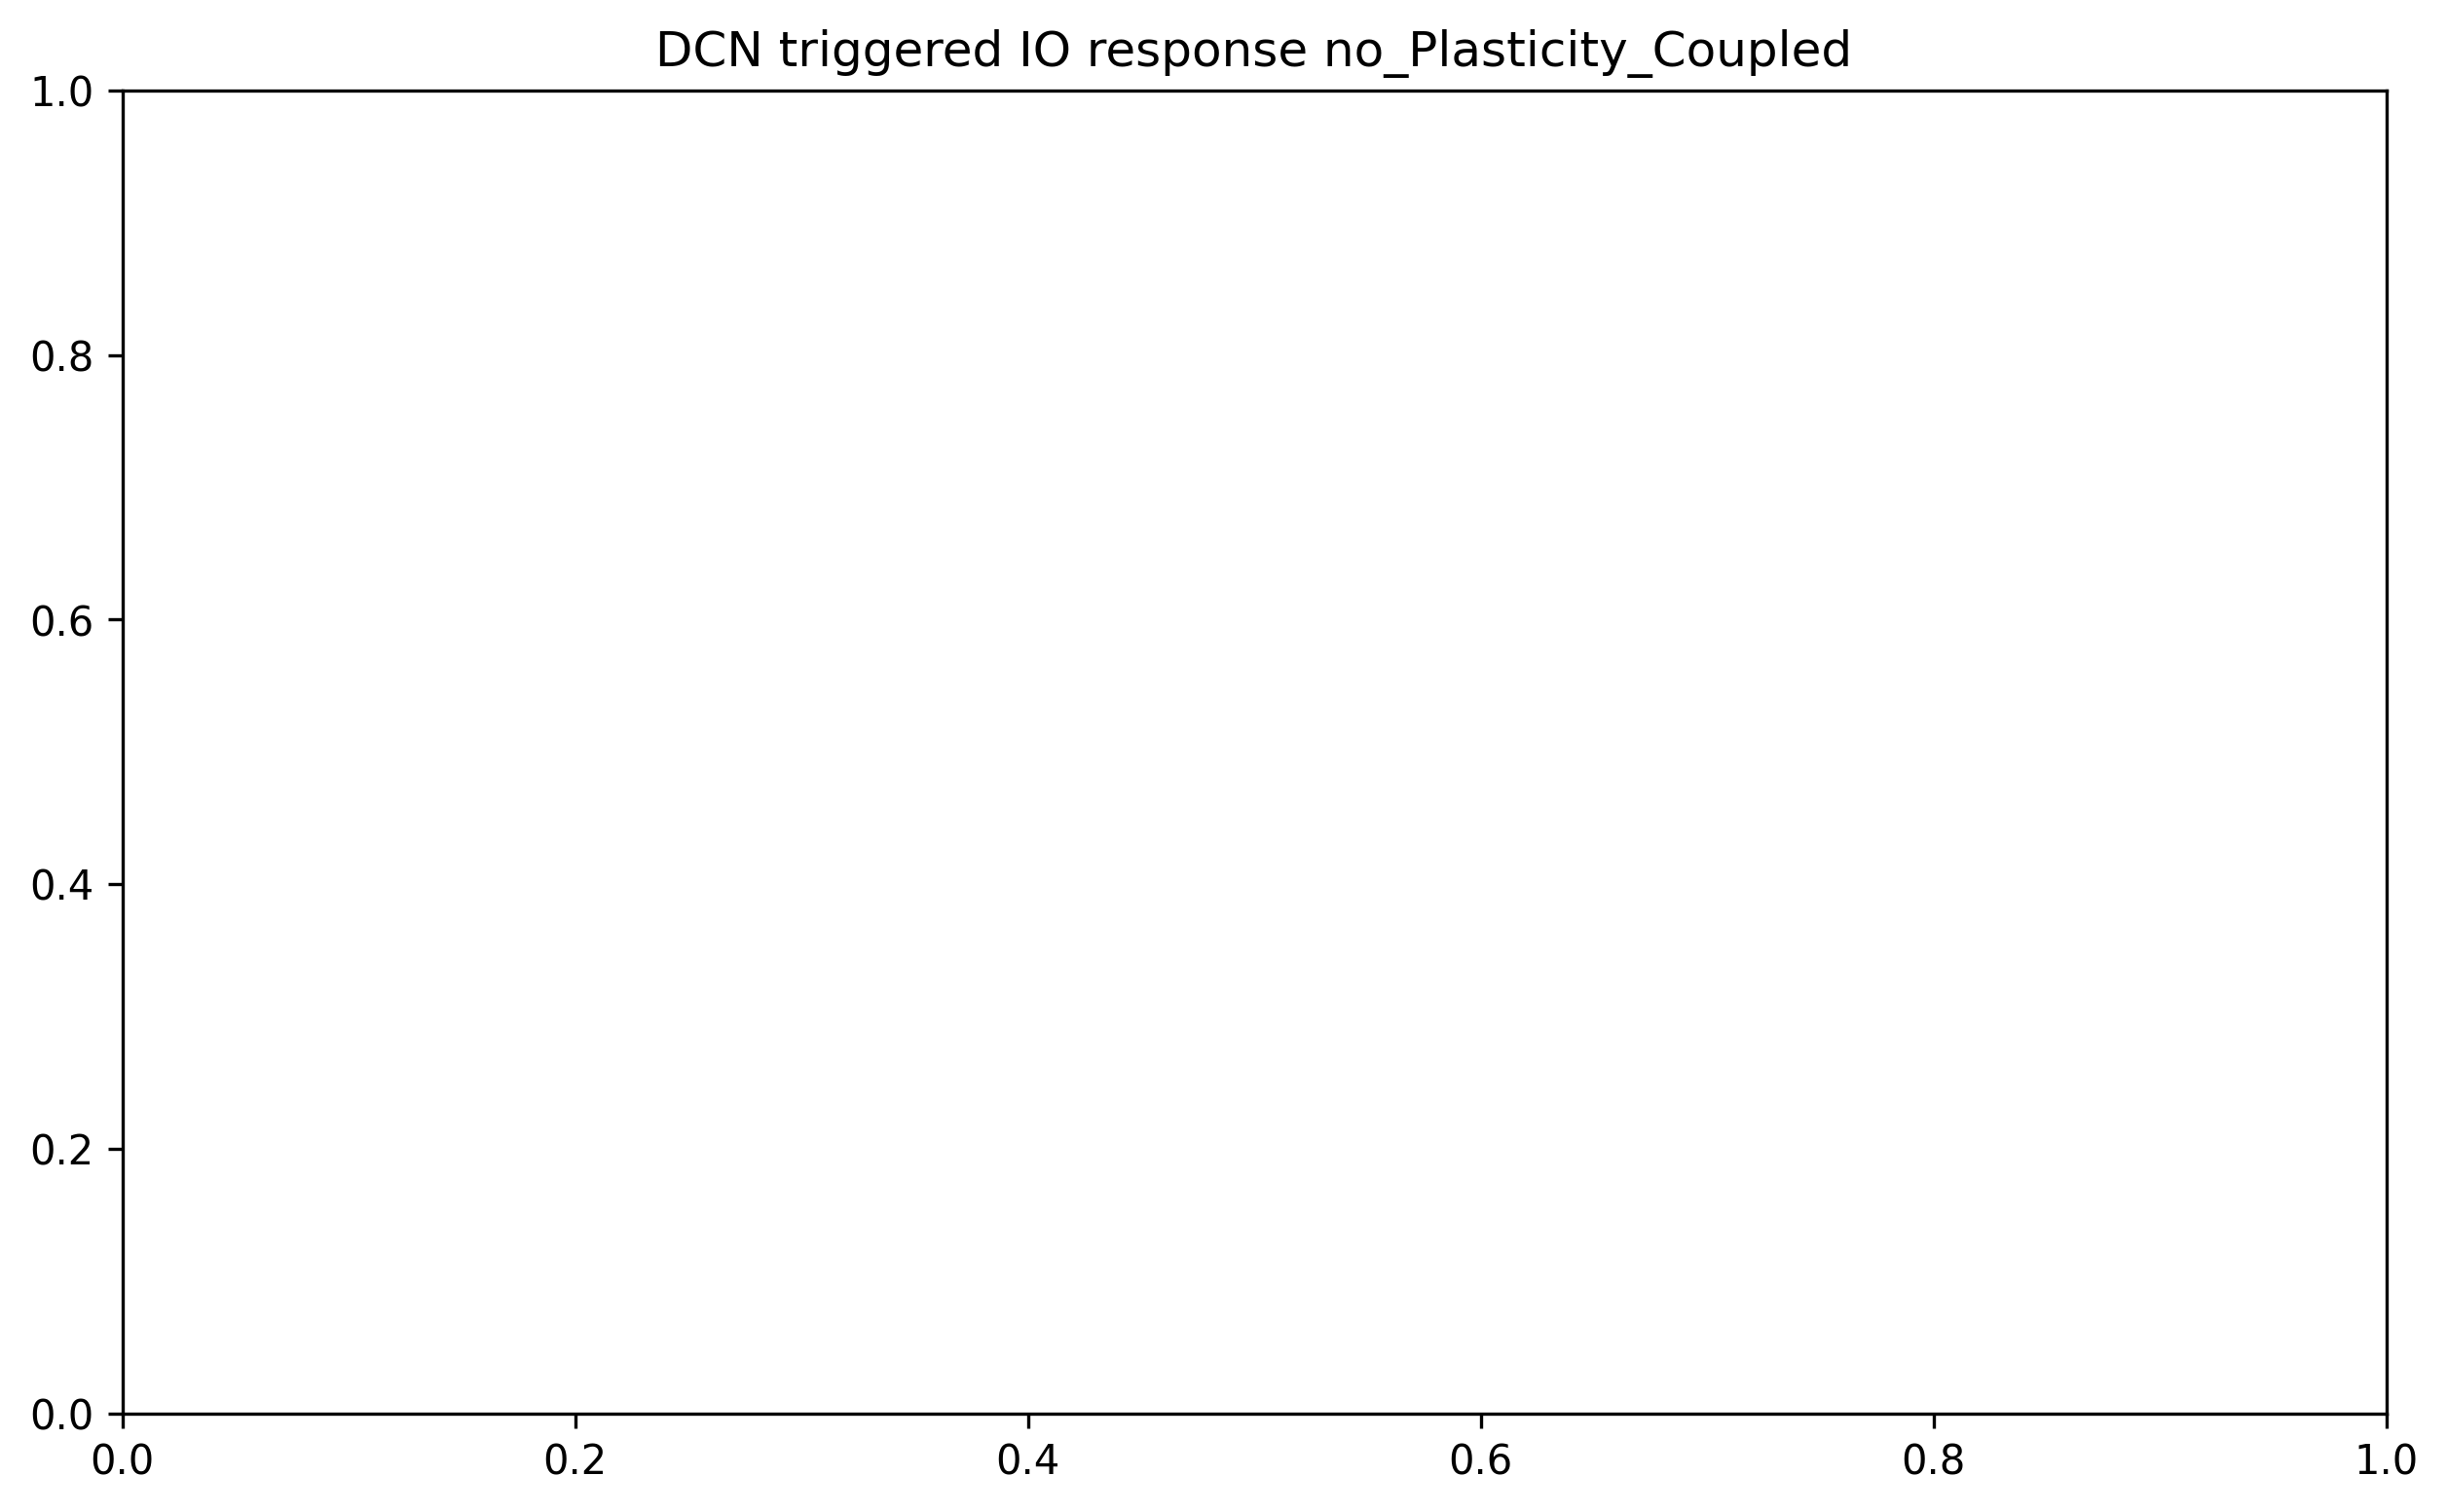

In [10]:
coupling = '_Coupled'
for zebrin in zebrin_range:
    if zebrin == 'positive':
        cmap = plt.get_cmap('Blues')
    elif zebrin == 'negative':
        cmap = plt.get_cmap('Reds')
    for plasticity in ['no_Plasticity','after_Plasticity']:
        figure(figsize=(10,6),dpi=300)
        title(f'DCN triggered IO response {plasticity}{coupling}')
        for dcn_num in range(N_Cells_DCN):
            IO_trig_avg = df_all_DCN_trig_IO[(df_all_DCN_trig_IO['cell']==dcn_num)&(df_all_DCN_trig_IO['zebrin']==zebrin)&(df_all_DCN_trig_IO['plasticity']==plasticity)&(df_all_DCN_trig_IO['f0']==f0)&(df_all_DCN_trig_IO['coupling']==coupling)].iloc[0]['IO_trig_avg']
            plot(linspace(-step*1000,step*1000,len(IO_trig_avg)),IO_trig_avg-IO_trig_avg[0], linestyle=linstyle[plasticity],lw=2,color=cmap((2+10*dcn_num)),alpha=0.7,label=plasticity)
        xlim(-1000,1000)
        ylabel('Membrane potential (mV)')
        xlabel('Time (ms)')
        ylim(-2.0,2.5)
        # plt.legend()
#         axis('off')
        sns.despine(trim=True,offset=10)
        plt.savefig(f'CN_IO_{zebrin}{plasticity}.svg')
        plt.show()
        
        io_heatmap = []
        for dcn_num in range(N_Cells_DCN):
            response = df_all_DCN_trig_IO[(df_all_DCN_trig_IO['cell']==dcn_num)&(df_all_DCN_trig_IO['zebrin']==zebrin)&(df_all_DCN_trig_IO['plasticity']==plasticity)&(df_all_DCN_trig_IO['f0']==f0)&(df_all_DCN_trig_IO['coupling']==coupling)].iloc[0]['IO_trig_avg']
            io_heatmap.append(response)

        cbar_kws = { 'ticks' : [-62,-60,-58] }
        fig=figure(figsize=(12,2),dpi=300)
        title(f'DCN triggered IO response Zebrin {zebrin} {plasticity}{coupling}')
        sns.heatmap(io_heatmap,vmin=np.min(io_heatmap),vmax=np.max(io_heatmap),cmap = plt.get_cmap('coolwarm_r'),cbar_kws = cbar_kws)
#         axvline(len(response)/2,color='k')
#         xticks(linspace(-step*1000,step*1000,len(IO_trig_avg)))
        axis('off')
        sns.despine(trim=True,offset=10)
        plt.savefig(f'CN_IO_heatmap_{zebrin}{plasticity}.svg')
        plt.show()

In [ ]:
%%time
data=[]
for f0 in f0_range[0:1]:
    for zebrin in ['negative','positive']:
        for plasticity in ['no_Plasticity','after_Plasticity']:
            for coupling in ['_Coupled','']:
                DCN_conn = Synaps['Seed_'+str(seed_number)].PC_DCN_Synapse_Targets
                PC_output = output_load_run('PC',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                DCN_output = output_load_run('DCN',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                PC_spikes = output_load_run('PC_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                PC_trig_big = []
                DCN_trig_big = []
                for pc_num in range(0,N_Cells_PC,30):
                    spike_times = PC_spikes[f'{pc_num}']
                    PC_trig = []
                    DCN_trig = []
                    for idx,val in enumerate(Synaps['Seed_'+str(seed_number)].PC_DCN_Synapse_Sources):
                        if val == pc_num:
                            dcn_num = DCN_conn[idx]
                            for spike_time in spike_times:
                                start = int(spike_time*second/dt_rec)-int(step*second/dt_rec)
                                end = int(spike_time*second/dt_rec)+int(step*second/dt_rec)
                                if spike_time < step: continue
                                if spike_time+step > exp_run/second: continue
                                PC_trig.append(PC_output['v'][pc_num][start:end]/mV)
                                DCN_trig.append(DCN_output['v'][dcn_num][start:end]/mV)
                        else:
                            continue
                    if not PC_trig: continue
                    if not DCN_trig: continue 
                    PC_trig_avg = mean(PC_trig,axis=0)
                    DCN_trig_avg = mean(DCN_trig,axis=0)
                    row=dict(cell=pc_num,f0=f0,zebrin=zebrin,plasticity=plasticity,coupling=coupling,PC_trig_avg=PC_trig_avg,DCN_trig_avg=DCN_trig_avg)
                    data.append(row)
df_all_PC_trig_DCN = pd.DataFrame(data)    

In [ ]:
%%time
t_start = 1 * second
t_stop = 59 * second
bin_size = 1 * second
coupling = '_Coupled'

cell_pop_sizes = dict(PC=N_Cells_PC,IO=N_Cells_IO,DCN=N_Cells_DCN)
colors = dict(positive='#1c4981',negative='#8a1218')
names = {}
for plasticity in plasticity_range:
    if plasticity == 'no_Plasticity': names[f'{plasticity}'] = 'NP'
    elif plasticity == 'Plasticity': names[f'{plasticity}'] = 'P1'
    elif plasticity == 'Plasticity2': names[f'{plasticity}'] = 'P2'
    elif plasticity == 'Plasticity3': names[f'{plasticity}'] = 'P3'
    elif plasticity == 'Plasticity4': names[f'{plasticity}'] = 'P4'
    elif plasticity == 'after_Plasticity': names[f'{plasticity}'] = 'AP1'
    elif plasticity == 'after_Plasticity2': names[f'{plasticity}'] = 'AP2'
    elif plasticity == 'after_Plasticity3': names[f'{plasticity}'] = 'AP3'
    elif plasticity == 'after_Plasticity4': names[f'{plasticity}'] = 'AP4'
        

data = []
for coupling in (['', '_Coupled']):
    for cell_name in ['PC','DCN','IO']:
        for zebrin in zebrin_range:
            for order,plasticity in enumerate(['after_Plasticity','no_Plasticity']):
                spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for cell_num in range(cell_pop_sizes[cell_name]):
                    spikes = spikes_output[f'{cell_num}']
                    bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
                    spike_counts, _ = np.histogram(spikes, bins=bin_edges)
                    mean_count = spike_counts / bin_size
                    row = dict(frequency = mean(mean_count/Hz))
                    row['cell'] = cell_name
                    row['plasticity'] = names[f'{plasticity}']
                    row['zebrin'] = zebrin
                    row['coupling'] = coupling
                    row['order'] = f'{order}'+names[f'{plasticity}']
                    data.append(row)
df_ff = pd.DataFrame(data)


In [ ]:
var = 'frequency'
x = {}
y = {}
for cell_name in ['PC','IO','DCN']:
    x[cell_name] = {}
    y[cell_name] = {}
    for zebrin in ['negative','positive']:
        df_data = df_ff[(df_ff["coupling"]==coupling) & (df_ff["cell"]==cell_name) & (df_ff["zebrin"]==zebrin)]
        Q1, Q3 = percentile(df_data[var],[5,95])
        IQR = Q3 - Q1    #IQR is interquartile range. 
        lower_boundary = Q1 - 1.5 * IQR
        upper_boundary = Q3 + 1.5 * IQR
        df_data2 = df_data[(df_data[var] < upper_boundary) & (df_data[var] > lower_boundary)]
        fig = plt.figure(dpi=300)
        flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
        bp = df_data2.boxplot(column=var, by=['plasticity'], grid=False, figsize=(4,3), widths=0.05, fontsize=15,
                             color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                             boxprops=dict(linestyle='-', linewidth=2),
                             flierprops=dict(linestyle='-', linewidth=1.5),
                             medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                             whiskerprops=dict(linestyle='-', linewidth=1.5),
                             capprops=dict(linestyle='-', linewidth=1.5),
                         positions=[2,1],ax = plt.gca())      
        title(f'')#title(f'CF Pauses {plasticity}{coupling}')
#         colors = dict(positive='b',negative='r')
        x[cell_name][zebrin] = {}
        y[cell_name][zebrin] = {}
        for i,plasticity in enumerate(['no_Plasticity','after_Plasticity']):
            y[cell_name][zebrin][f'{plasticity}'] = df_data2.frequency[(df_data2.zebrin==zebrin) & (df_data2.plasticity==names[f'{plasticity}'])].dropna()
            x[cell_name][zebrin][f'{plasticity}'] = [1+i]*len(y[cell_name][zebrin][f'{plasticity}'])
            scatter(x[cell_name][zebrin][f'{plasticity}'], y[cell_name][zebrin][f'{plasticity}'],color=f'{colors[zebrin]}', alpha=0.7)
        toPlot = zip(x[cell_name][zebrin]['no_Plasticity'], y[cell_name][zebrin]['no_Plasticity'], x[cell_name][zebrin]['after_Plasticity'], y[cell_name][zebrin]['after_Plasticity'])
        for tuple in toPlot:
            plot([tuple[0], tuple[2]], [tuple[1], tuple[3]], color=f'{colors[zebrin]}',alpha=0.1)
        xticks([1,2],['no_Plasticity','after_Plasticity'])
        if cell_name == 'PC':
            ylim([30,110])
        elif cell_name == 'IO':
            ylim([0,3.3])
        elif cell_name == 'DCN':
            ylim([15,60])
#         plt.savefig(f'{cell_name}_{var}_boxplot_{zebrin}.svg')
        sns.despine(trim=True,offset = 10)
        plt.show()

In [ ]:
%%time 

skip = 5*ms/second # seconds
transient_time = 10000
data = []
# 
for zebrin in zebrin_range:
    zeb_name = 'Z+'
    if zebrin == 'negative': zeb_name = 'Z-'
    for coupling in coupling_range:
        coup_name = 'Coup'
        if coupling == '': coup_name = 'Uncoup'
        for plasticity in ['no_Plasticity','after_Plasticity']:
            plas_name = 'NP'
            if plasticity == 'Plasticity': plas_name = 'P'
            elif plasticity == 'after_Plasticity': plas_name = 'AP'
            IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources
            IO_Spikes = output_load_run('IO_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
            PC_Spikes = output_load_run('PC_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
            for pc_cell_id in range(N_Cells_PC):
                pauses = []
                io_cell_id = IO_num_con[pc_cell_id]
                row = dict(PC=pc_cell_id)
                row['IO'] = io_cell_id
                for io_spike in IO_Spikes[f'{io_cell_id}']:
                    if io_spike < transient_time*ms/second: continue
                    hit = None
                    for pc_spike in PC_Spikes[f'{pc_cell_id}']:
                        if pc_spike <= io_spike+skip:
                            continue
                        hit = pc_spike
                        break
                    if hit is not None:
                        pauses.append((hit - io_spike))
                pauses = np.array(pauses)*1e3
                row['average_pause'] = mean(pauses)
                row['zebrin'] = zebrin
                row['plasticity'] = plasticity
                row['coupling'] = coupling
                data.append(row)
                
df_pauses = pd.DataFrame(data).dropna()
colors = dict(positive='#1c4981',negative='#8a1218')

In [ ]:
var = 'average_pause'
x = {}
y = {}
for zebrin in ['negative','positive']:
    df_data = df_pauses[(df_pauses["coupling"]==coupling)&(df_pauses["zebrin"]==zebrin)]
    Q1, Q3 = percentile(df_data[var],[5,95])
    IQR = Q3 - Q1    #IQR is interquartile range. 
    lower_boundary = Q1 - 1.5 * IQR
    upper_boundary = Q3 + 1.5 * IQR
    df_data2 = df_data[(df_data[var] < upper_boundary) & (df_data[var] > lower_boundary)]
    fig = plt.figure(dpi=300)
    flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
    bp = df_data2.boxplot(column=var, by=['plasticity'], grid=False, figsize=(4,3), widths=0.05, fontsize=15,
                         color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                         boxprops=dict(linestyle='-', linewidth=2),
                         flierprops=dict(linestyle='-', linewidth=1.5),
                         medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                         whiskerprops=dict(linestyle='-', linewidth=1.5),
                         capprops=dict(linestyle='-', linewidth=1.5),
                         positions=[2,1],ax = plt.gca()) 
    title(f'')#title(f'CF Pauses {plasticity}{coupling}')
    colors = dict(positive='#1c4981',negative='#8a1218')
    x[zebrin] = {}
    y[zebrin] = {}
    for i,plasticity in enumerate(['no_Plasticity','after_Plasticity']):
        y[zebrin][f'{plasticity}'] = df_data2.average_pause[(df_data2.plasticity==plasticity)].dropna()
        x[zebrin][f'{plasticity}'] = [1+i]*len(y[zebrin][f'{plasticity}'])
        scatter(x[zebrin][f'{plasticity}'], y[zebrin][f'{plasticity}'],color=f'{colors[zebrin]}', alpha=0.9)
    toPlot = zip(x[zebrin]['no_Plasticity'], y[zebrin]['no_Plasticity'], x[zebrin]['after_Plasticity'], y[zebrin]['after_Plasticity'])
    for tuple in toPlot:
        plot([tuple[0], tuple[2]], [tuple[1], tuple[3]], color=f'{colors[zebrin]}',alpha=0.2)
    xticks([1,2],['no_Plasticity','after_Plasticity'])
    ylim([22,70])
    sns.despine(trim=True)
    plt.savefig(f'CF_{var}_boxplot_{zebrin}.svg')
    plt.show()